In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from gplearn.genetic import SymbolicClassifier
from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [3]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None):
    function_vars = None
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names is None:
            function_vars = function.atoms(Symbol)
            print(function_vars)
        else:
            function_vars = [sym.symbols(variable_name, real=True) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        function_values = []
        for data_point in data_points:
            function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
            try:
                function_value = float(function_value)
            except TypeError as te:
                #print('te', te)
                #print('function_value', function_value)
                #print('function', function)
                #print('function_vars', function_vars, type(function_vars))
                function_value = np.inf
            function_values.append(function_value)
    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

In [4]:
def print_decision_tree_nodes(decision_tree): 
    
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

## Load Histograms and Data Statistics

In [5]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [6]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000,-3.043901,-1.0,9.212087,110.625000,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.138240,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625000,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [7]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [8]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [9]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [10]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [11]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [12]:
summarizing_statistics_replica

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[4.05498868e+00 1.61819320e+00 1.43801350e+00...
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,[[ 4.60037788e+00 1.66251134e+00 1.59768757e...
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,[[ 1.53948274e+00 2.18804150e-01 7.78027734e...
off_replica,16741535,-2.791476,4.517446,-1.396657,107.331233,-9.894227,-37.217121,-4.272182,0.000004,8.534652,106.621120,4.482172,2402.991829,[[ 1.77712398e+00 9.46578975e-02 8.42137846e...
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[8.46656243e+00 1.04568770e+01 3.70312553e+00...
all_replica,26381042,-0.944794,6.939326,-0.547978,111.501253,-9.894227,-37.217121,-4.272182,0.000004,10.007755,117.621411,6.767623,2402.992395,[[8.73149553e+00 8.43511366e+00 3.84013568e+00...


In [13]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [14]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [15]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [16]:
pump_data_replica.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
count,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07
mean,-9.447940e-01,6.939326e+00,-5.479782e-01,1.115013e+02,3.653952e-01
std,2.954910e+00,9.601276e+00,1.405716e+00,1.955450e+02,4.815408e-01
min,-9.894227e+00,-3.721712e+01,-4.272182e+00,4.127640e-06,0.000000e+00
25%,-3.370405e+00,1.604177e+00,-1.820977e+00,3.802474e+01,0.000000e+00
50%,-2.187935e+00,4.925814e+00,-9.364350e-01,7.603595e+01,0.000000e+00
75%,1.350188e+00,8.836291e+00,5.890964e-01,1.140709e+02,1.000000e+00
max,1.000776e+01,1.176214e+02,6.767623e+00,2.402992e+03,1.000000e+00


In [17]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [18]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

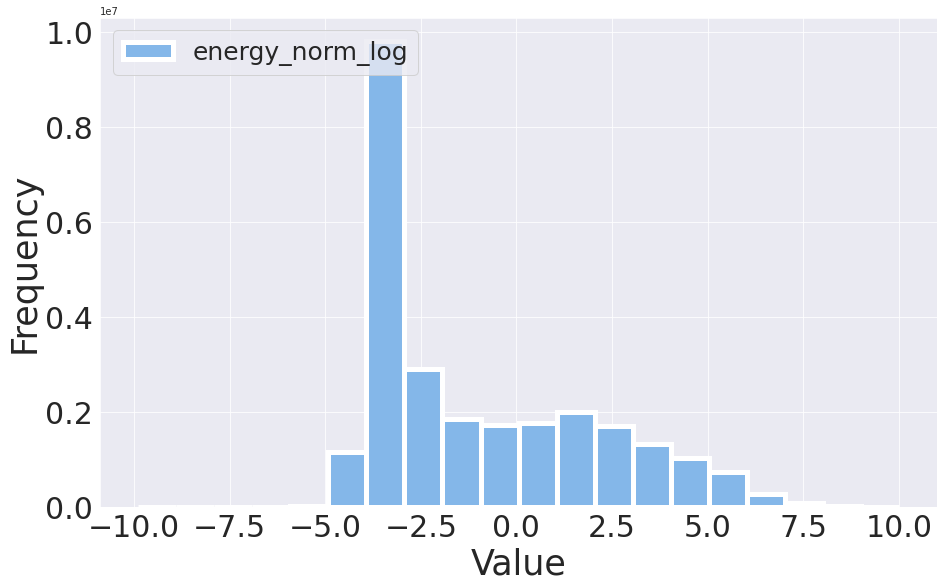

In [19]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

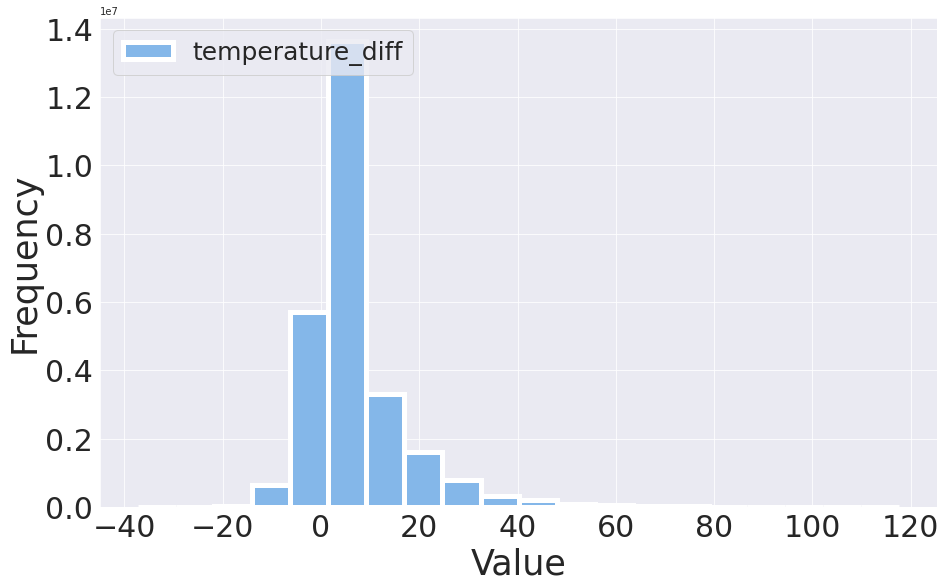

In [20]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

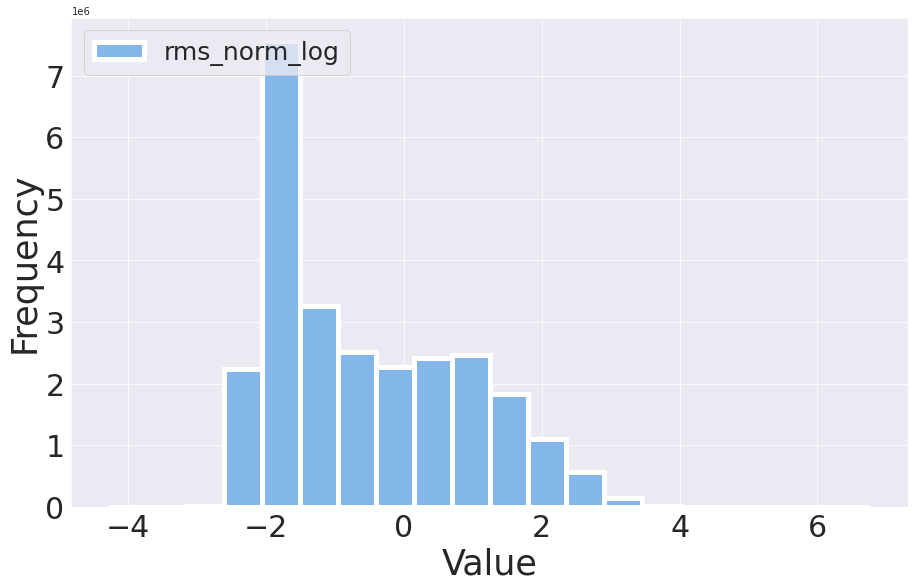

In [21]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

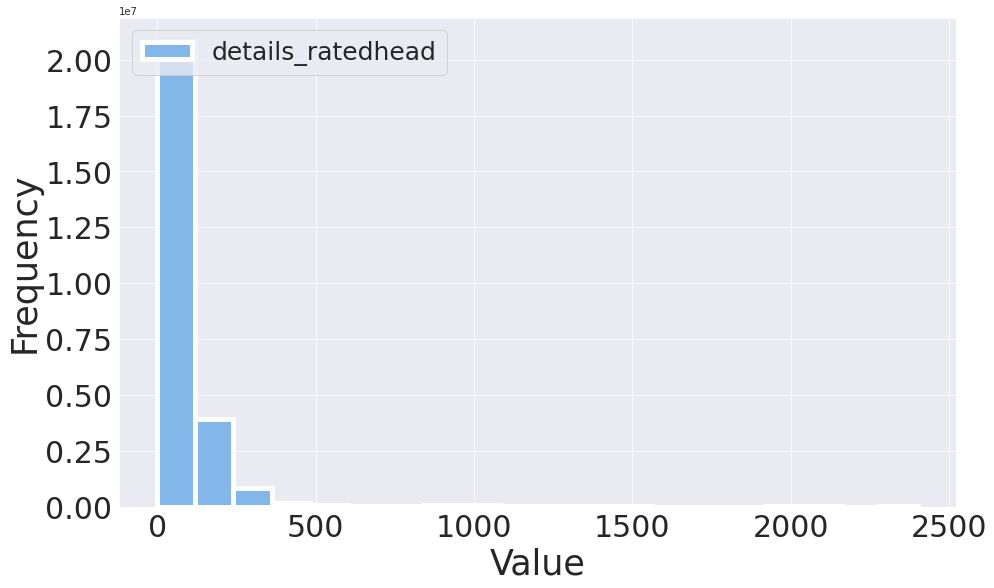

In [22]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [23]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [24]:
data = pump_data_replica.sample(n=10000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1


In [25]:
X_data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,-3.435427,2.008345,-1.831309,44.514913
13018525,-3.043470,4.328306,-2.011905,57.427111
22758968,0.059526,3.589398,0.421158,32.645146
26049008,-3.589604,2.368120,-2.103114,466.114163
4688620,0.485113,9.553305,1.172251,54.346425


In [26]:
y_data.head()

,state
13880350,0
13018525,0
22758968,0
26049008,0
4688620,1


In [27]:
X_data.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.903752,6.957620,-0.529029,108.840560
std,2.940251,9.583776,1.391853,179.754406
min,-5.676228,-22.095298,-2.981257,0.004160
25%,-3.347392,1.625078,-1.804050,38.281687
50%,-2.114641,4.917930,-0.892979,77.509069
75%,1.360277,8.790616,0.605675,114.241249
max,8.326624,108.964905,3.778478,2379.037789


In [28]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 13880350 to 9629643
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy_norm_log    10000 non-null  float64
 1   temperature_diff   10000 non-null  float64
 2   rms_norm_log       10000 non-null  float64
 3   details_ratedhead  10000 non-null  float64
dtypes: float64(4)
memory usage: 390.6 KB


# Symbolic Metamodeling

In [29]:
metamodeling_hyperparams = {
    'num_iter': 3,#500,
    'batch_size': 128,
    'learning_rate': 0.005,        
    'dataset_size': 50000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 50,
    'restarts': 10,
}

symbolic_classification_hyperparams = {     
    'dataset_size': 5000,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True
symbolic_classification = True

In [30]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.9024

In [31]:
data = pump_data_replica.sample(n=metamodeling_hyperparams['dataset_size'])

data_scaled = np.empty_like(data.values.T[:-1])
scaler_list = []

for index, feature in enumerate(data.values.T[:-1]):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    data_scaled[index] = feature_scaled
    
data_scaled = pd.DataFrame(data= data_scaled.T, index=data.index, columns=list(data.columns)[:-1])

In [32]:
data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
3228774,0.722642,5.048562,0.478871,102.441835,1
6648753,2.069493,24.442959,1.769626,66.284119,1
25558960,-1.145248,4.071129,-0.063827,184.503801,0
17578382,-3.199043,4.780609,-1.628835,27.827720,0
4363318,1.854438,2.216334,0.973370,60.624418,1


In [33]:
data_scaled.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
3228774,0.455865,0.214644,0.477619,0.042774
6648753,0.538867,0.377020,0.651340,0.027712
25558960,0.340754,0.206460,0.404578,0.076959
17578382,0.214185,0.212400,0.193946,0.011692
4363318,0.525614,0.190931,0.544173,0.025354


In [34]:
X_data = data.drop(['state'], axis=1).values #frac=0.1
y_data = data[['state']].values #frac=0.1

X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   


In [35]:
X_data_scaled = data_scaled.values 
X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

In [36]:
print(X_data.shape)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()

print(y_data.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(50000, 4)
(28125, 4)
(9375, 4)
(12500, 4)

(50000, 1)
(28125, 1)
(9375, 1)
(12500, 1)


## Evaluate Model

In [37]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))


Accuracy: 0.90664


In [38]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train, 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [39]:
%load_ext autoreload 

In [40]:
if False:
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from xgboost import XGBClassifier
    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split


    data          = pd.read_csv("data/absenteeism.csv", delimiter=';')

    feature_names = ['Transportation expense', 'Distance from Residence to Work',
                     'Service time', 'Age', 'Work load Average/day ', 'Hit target',
                     'Disciplinary failure', 'Education', 'Son', 'Social drinker',
                     'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']

    scaler        = MinMaxScaler(feature_range=(0, 1))
    X             = scaler.fit_transform(data[feature_names])
    Y             = ((data['Absenteeism time in hours'] > 4) * 1) 

    X_train_abse, X_test_abse, Y_train_abse, Y_test_abse = train_test_split(X, Y, test_size=0.33, random_state=42)

    model         = XGBClassifier()

    model.fit(X_train_abse, Y_train_abse)

In [41]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]:  
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [42]:
#%autoreload 2
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_train_scaled.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled, #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model_scaled.predict(X_test_scaled)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]


restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.842
Iteration: 1 	--- Loss: 35.041
Iteration: 2 	--- Loss: 38.002
Iteration: 3 	--- Loss: 36.659
Iteration: 4 	--- Loss: 36.023
Iteration: 5 	--- Loss: 36.162
Iteration: 6 	--- Loss: 34.193
Iteration: 7 	--- Loss: 34.989
Iteration: 8 	--- Loss: 36.160
Iteration: 9 	--- Loss: 33.841
Iteration: 10 	--- Loss: 35.420
Iteration: 11 	--- Loss: 34.392
Iteration: 12 	--- Loss: 35.069
Iteration: 13 	--- Loss: 34.263
Iteration: 14 	--- Loss: 35.108
Iteration: 15 	--- Loss: 35.732
Iteration: 16 	--- Loss: 31.520
Iteration: 17 	--- Loss: 33.090
Iteration: 18 	--- Loss: 31.472
Iteration: 19 	--- Loss: 33.349
Iteration: 20 	--- Loss: 29.448
Iteration: 21 	--- Loss: 31.078
Iteration: 22 	--- Loss: 36.169
Iteration: 23 	--- Loss: 37.518
Iteration: 24 	--- Loss: 36.470
Iteration: 25 	--- Loss: 41.831
Iteration: 26 	--- Loss: 43.902
Iteration: 27 	--- Loss: 44.953
Iteration: 28 	--- Loss: 46.863
Iteration: 29 	--- Loss: 50.071
Iteration: 30 	--- Loss: 48.256
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [04:59<49:50, 299.06s/it]

Iteration: 71 	--- Loss: 32.948
Early Stopping requirement reached after 71 Iterations
New Global Minimum: 29.44776203284286


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.560
Iteration: 1 	--- Loss: 38.188
Iteration: 2 	--- Loss: 35.344
Iteration: 3 	--- Loss: 38.547
Iteration: 4 	--- Loss: 39.594
Iteration: 5 	--- Loss: 36.176
Iteration: 6 	--- Loss: 36.853
Iteration: 7 	--- Loss: 38.654
Iteration: 8 	--- Loss: 37.168
Iteration: 9 	--- Loss: 37.845
Iteration: 10 	--- Loss: 36.777
Iteration: 11 	--- Loss: 37.409
Iteration: 12 	--- Loss: 37.262
Iteration: 13 	--- Loss: 35.924
Iteration: 14 	--- Loss: 36.601
Iteration: 15 	--- Loss: 35.581
Iteration: 16 	--- Loss: 38.842
Iteration: 17 	--- Loss: 37.633
Iteration: 18 	--- Loss: 36.396
Iteration: 19 	--- Loss: 36.220
Iteration: 20 	--- Loss: 35.481
Iteration: 21 	--- Loss: 39.347
Iteration: 22 	--- Loss: 37.593
Iteration: 23 	--- Loss: 37.463
Iteration: 24 	--- Loss: 37.820
Iteration: 25 	--- Loss: 38.785
Iteration: 26 	--- Loss: 37.104
Iteration: 27 	--- Loss: 39.648
Iteration: 28 	--- Loss: 36.156
Iteration: 29 	--- Loss: 37.960
Iteration: 30 	--- Loss: 37.830
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [15:17<1:13:04, 487.16s/it]

Iteration: 164 	--- Loss: 36.483
Early Stopping requirement reached after 164 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.349
Iteration: 1 	--- Loss: 36.823
Iteration: 2 	--- Loss: 36.158
Iteration: 3 	--- Loss: 34.745
Iteration: 4 	--- Loss: 37.835
Iteration: 5 	--- Loss: 36.390
Iteration: 6 	--- Loss: 37.814
Iteration: 7 	--- Loss: 39.543
Iteration: 8 	--- Loss: 36.383
Iteration: 9 	--- Loss: 34.977
Iteration: 10 	--- Loss: 39.295
Iteration: 11 	--- Loss: 35.859
Iteration: 12 	--- Loss: 36.830
Iteration: 13 	--- Loss: 36.604
Iteration: 14 	--- Loss: 35.987
Iteration: 15 	--- Loss: 35.759
Iteration: 16 	--- Loss: 38.557
Iteration: 17 	--- Loss: 38.637
Iteration: 18 	--- Loss: 37.564
Iteration: 19 	--- Loss: 37.456
Iteration: 20 	--- Loss: 37.655
Iteration: 21 	--- Loss: 37.267
Iteration: 22 	--- Loss: 38.018
Iteration: 23 	--- Loss: 39.312
Iteration: 24 	--- Loss: 35.098
Iteration: 25 	--- Loss: 35.328
Iteration: 26 	--- Loss: 35.192
Iteration: 27 	--- Loss: 37.583
Iteration: 28 	--- Loss: 35.555
Iteration: 29 	--- Loss: 37.677
Iteration: 30 	--- Loss: 37.794
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [20:00<52:31, 393.93s/it]  

Iteration: 89 	--- Loss: 37.577
Early Stopping requirement reached after 89 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.043
Iteration: 1 	--- Loss: 38.050
Iteration: 2 	--- Loss: 34.719
Iteration: 3 	--- Loss: 37.323
Iteration: 4 	--- Loss: 35.028
Iteration: 5 	--- Loss: 35.069
Iteration: 6 	--- Loss: 31.996
Iteration: 7 	--- Loss: 33.370
Iteration: 8 	--- Loss: 34.083
Iteration: 9 	--- Loss: 36.596
Iteration: 10 	--- Loss: 46.683
Iteration: 11 	--- Loss: 59.588
Iteration: 12 	--- Loss: 62.315
Iteration: 13 	--- Loss: 48.243
Iteration: 14 	--- Loss: 35.008
Iteration: 15 	--- Loss: 40.469
Iteration: 16 	--- Loss: 42.583
Iteration: 17 	--- Loss: 39.346
Iteration: 18 	--- Loss: 40.771
Iteration: 19 	--- Loss: 37.266
Iteration: 20 	--- Loss: 35.729
Iteration: 21 	--- Loss: 35.257
Iteration: 22 	--- Loss: 34.518
Iteration: 23 	--- Loss: 36.277
Iteration: 24 	--- Loss: 35.440
Iteration: 25 	--- Loss: 37.592
Iteration: 26 	--- Loss: 38.588
Iteration: 27 	--- Loss: 36.685
Iteration: 28 	--- Loss: 37.364
Iteration: 29 	--- Loss: 40.844
Iteration: 30 	--- Loss: 38.941
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [37:20<1:15:42, 648.91s/it]

Iteration: 298 	--- Loss: 14.538
Early Stopping requirement reached after 298 Iterations
New Global Minimum: 13.259667789127779


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.672
Iteration: 1 	--- Loss: 37.014
Iteration: 2 	--- Loss: 37.152
Iteration: 3 	--- Loss: 36.507
Iteration: 4 	--- Loss: 37.443
Iteration: 5 	--- Loss: 37.085
Iteration: 6 	--- Loss: 35.561
Iteration: 7 	--- Loss: 36.839
Iteration: 8 	--- Loss: 38.951
Iteration: 9 	--- Loss: 34.156
Iteration: 10 	--- Loss: 36.190
Iteration: 11 	--- Loss: 34.283
Iteration: 12 	--- Loss: 33.478
Iteration: 13 	--- Loss: 33.969
Iteration: 14 	--- Loss: 32.949
Iteration: 15 	--- Loss: 34.607
Iteration: 16 	--- Loss: 33.547
Iteration: 17 	--- Loss: 40.242
Iteration: 18 	--- Loss: 59.254
Iteration: 19 	--- Loss: 76.155
Iteration: 20 	--- Loss: 89.433
Iteration: 21 	--- Loss: 51.862
Iteration: 22 	--- Loss: 37.214
Iteration: 23 	--- Loss: 47.437
Iteration: 24 	--- Loss: 41.935
Iteration: 25 	--- Loss: 39.401
Iteration: 26 	--- Loss: 38.158
Iteration: 27 	--- Loss: 35.902
Iteration: 28 	--- Loss: 33.946
Iteration: 29 	--- Loss: 36.330
Iteration: 30 	--- Loss: 38.294
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [43:57<55:48, 558.16s/it]  

Iteration: 94 	--- Loss: 15.287
Early Stopping requirement reached after 94 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.184
Iteration: 1 	--- Loss: 36.703
Iteration: 2 	--- Loss: 36.572
Iteration: 3 	--- Loss: 36.741
Iteration: 4 	--- Loss: 37.213
Iteration: 5 	--- Loss: 36.392
Iteration: 6 	--- Loss: 36.250
Iteration: 7 	--- Loss: 33.531
Iteration: 8 	--- Loss: 33.949
Iteration: 9 	--- Loss: 33.683
Iteration: 10 	--- Loss: 33.345
Iteration: 11 	--- Loss: 32.994
Iteration: 12 	--- Loss: 35.800
Iteration: 13 	--- Loss: 36.481
Iteration: 14 	--- Loss: 31.043
Iteration: 15 	--- Loss: 35.759
Iteration: 16 	--- Loss: 41.122
Iteration: 17 	--- Loss: 70.900
Iteration: 18 	--- Loss: 81.467
Iteration: 19 	--- Loss: 80.864
Iteration: 20 	--- Loss: 43.197
Iteration: 21 	--- Loss: 44.056
Iteration: 22 	--- Loss: 43.927
Iteration: 23 	--- Loss: 39.412
Iteration: 24 	--- Loss: 37.424
Iteration: 25 	--- Loss: 36.269
Iteration: 26 	--- Loss: 35.583
Iteration: 27 	--- Loss: 39.782
Iteration: 28 	--- Loss: 41.800
Iteration: 29 	--- Loss: 40.160
Iteration: 30 	--- Loss: 41.605
Iteration: 31 	---


restart loop:  55%|█████▍    | 6/11 [56:22<51:47, 621.58s/it]

Iteration: 171 	--- Loss: 23.436
Early Stopping requirement reached after 171 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.635
Iteration: 1 	--- Loss: 36.371
Iteration: 2 	--- Loss: 36.368
Iteration: 3 	--- Loss: 37.142
Iteration: 4 	--- Loss: 34.506
Iteration: 5 	--- Loss: 36.251
Iteration: 6 	--- Loss: 37.042
Iteration: 7 	--- Loss: 37.621
Iteration: 8 	--- Loss: 34.310
Iteration: 9 	--- Loss: 38.505
Wrong c Value: -0.026830077
te can't convert complex to float
function_value 3.7210623074178e-11 - 3.65917599153548e-11*I
function 6.33951250777464e-8*x**3.75267*exp(3.75267*I*pi)*hyper((1.0, 1.0), (4.87792,), 0.0268300771713257*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.30133747934472e-10 - 1.27969447106837e-10*I
function 6.33951250777464e-8*x**3.75267*exp(3.75267*I*pi)*hyper((1.0, 1.0), (4.87792,), 0.0268300771713257*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 9.11040432528419e-11 - 8.95888593797682e-11*I
function 6.33951250777464e-8*x**3.75267*exp(3.75267*I*pi


restart loop:  64%|██████▎   | 7/11 [56:58<28:40, 430.04s/it]

<class 'list'>
te can't convert complex to float
function_value 4.76183429315668e-10 - 4.68263852676006e-10*I
function 6.33951250777464e-8*x**3.75267*exp(3.75267*I*pi)*hyper((1.0, 1.0), (4.87792,), 0.0268300771713257*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.20640445720061e-11 - 7.08655217154417e-11*I
function 6.33951250777464e-8*x**3.75267*exp(3.75267*I*pi)*hyper((1.0, 1.0), (4.87792,), 0.0268300771713257*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.63282475269645e-9 - 1.60566866121569e-9*I
function 6.33951250777464e-8*x**3.75267*exp(3.75267*I*pi)*hyper((1.0, 1.0), (4.87792,), 0.0268300771713257*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.30349588305781e-10 - 1.28181697759863e-10*I
function 6.33951250777464e-8*x**3.75267*exp(3.75267*I*pi)*hyper((1.0, 1.0), (4.87792,), 0.0268300771713257*x*exp_polar(2*I*p

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 34.827
Iteration: 1 	--- Loss: 37.391
Iteration: 2 	--- Loss: 36.663
Iteration: 3 	--- Loss: 36.829
Iteration: 4 	--- Loss: 36.362
Iteration: 5 	--- Loss: 37.413
Iteration: 6 	--- Loss: 36.122
Iteration: 7 	--- Loss: 35.102
Iteration: 8 	--- Loss: 38.492
Iteration: 9 	--- Loss: 37.474
Iteration: 10 	--- Loss: 37.726
Iteration: 11 	--- Loss: 39.020
Iteration: 12 	--- Loss: 37.107
Iteration: 13 	--- Loss: 34.931
Iteration: 14 	--- Loss: 36.652
Iteration: 15 	--- Loss: 40.305
Iteration: 16 	--- Loss: 36.290
Iteration: 17 	--- Loss: 39.751
Iteration: 18 	--- Loss: 36.237
Iteration: 19 	--- Loss: 35.473
Iteration: 20 	--- Loss: 37.901
Iteration: 21 	--- Loss: 33.979
Iteration: 22 	--- Loss: 35.811
Iteration: 23 	--- Loss: 38.427
Iteration: 24 	--- Loss: 35.898
Iteration: 25 	--- Loss: 37.111
Iteration: 26 	--- Loss: 37.065
Iteration: 27 	--- Loss: 32.744
Iteration: 28 	--- Loss: 35.327
Iteration: 29 	--- Loss: 34.340
Iteration: 30 	--- Loss: 32.580
Iteration: 31 	---


restart loop:  73%|███████▎  | 8/11 [1:05:11<22:30, 450.22s/it]

Iteration: 112 	--- Loss: 35.116
Early Stopping requirement reached after 112 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.736
Iteration: 1 	--- Loss: 37.841
Iteration: 2 	--- Loss: 35.377
Iteration: 3 	--- Loss: 36.805
Iteration: 4 	--- Loss: 37.818
Iteration: 5 	--- Loss: 35.901
Iteration: 6 	--- Loss: 36.458
Iteration: 7 	--- Loss: 37.099
Iteration: 8 	--- Loss: 35.459
Iteration: 9 	--- Loss: 34.324
Iteration: 10 	--- Loss: 35.310
Iteration: 11 	--- Loss: 34.471
Iteration: 12 	--- Loss: 32.934
Iteration: 13 	--- Loss: 33.405
Iteration: 14 	--- Loss: 34.190
Iteration: 15 	--- Loss: 37.204
Iteration: 16 	--- Loss: 58.977
Iteration: 17 	--- Loss: 75.709
Iteration: 18 	--- Loss: 67.944
Iteration: 19 	--- Loss: 36.418
Iteration: 20 	--- Loss: 46.797
Iteration: 21 	--- Loss: 46.247
Iteration: 22 	--- Loss: 38.922
Iteration: 23 	--- Loss: 37.878
Iteration: 24 	--- Loss: 37.530
Iteration: 25 	--- Loss: 36.045
Iteration: 26 	--- Loss: 35.679
Iteration: 27 	--- Loss: 38.080
Iteration: 28 	--- Loss: 37.139
Iteration: 29 	--- Loss: 40.127
Iteration: 30 	--- Loss: 38.844
Iteration: 31 	---


restart loop:  82%|████████▏ | 9/11 [1:22:13<20:57, 628.98s/it]

Iteration: 291 	--- Loss: 14.072
Early Stopping requirement reached after 291 Iterations
New Global Minimum: 12.81618892268286


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 40.505
Iteration: 1 	--- Loss: 34.076
Iteration: 2 	--- Loss: 35.673
Iteration: 3 	--- Loss: 36.996
Iteration: 4 	--- Loss: 38.018
Iteration: 5 	--- Loss: 40.259
Iteration: 6 	--- Loss: 36.436
Iteration: 7 	--- Loss: 38.003
Iteration: 8 	--- Loss: 38.030
Iteration: 9 	--- Loss: 37.865
Iteration: 10 	--- Loss: 38.869
Iteration: 11 	--- Loss: 37.522
Iteration: 12 	--- Loss: 36.395
Iteration: 13 	--- Loss: 36.446
Iteration: 14 	--- Loss: 35.685
Iteration: 15 	--- Loss: 38.001
Iteration: 16 	--- Loss: 37.763
Iteration: 17 	--- Loss: 36.706
Iteration: 18 	--- Loss: 36.674
Iteration: 19 	--- Loss: 38.227
Iteration: 20 	--- Loss: 37.354
Iteration: 21 	--- Loss: 36.387
Iteration: 22 	--- Loss: 36.191
Iteration: 23 	--- Loss: 36.504
Iteration: 24 	--- Loss: 36.255
Iteration: 25 	--- Loss: 37.255
Iteration: 26 	--- Loss: 36.394
Iteration: 27 	--- Loss: 38.002
Iteration: 28 	--- Loss: 36.255
Iteration: 29 	--- Loss: 33.925
Iteration: 30 	--- Loss: 39.118
Iteration: 31 	---


restart loop:  91%|█████████ | 10/11 [1:26:32<08:34, 514.55s/it]

Iteration: 80 	--- Loss: 37.226
Early Stopping requirement reached after 80 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.076
Iteration: 1 	--- Loss: 37.832
Iteration: 2 	--- Loss: 35.808
Iteration: 3 	--- Loss: 40.370
Iteration: 4 	--- Loss: 35.332
Iteration: 5 	--- Loss: 38.343
Iteration: 6 	--- Loss: 37.463
Iteration: 7 	--- Loss: 35.161
Iteration: 8 	--- Loss: 36.951
Wrong c Value: -0.045506313
te can't convert complex to float
function_value 7.20526596624141e-10 - 1.14343665967209e-9*I
function 4.53494924407936e-7*x**3.67898*exp(3.67898*I*pi)*hyper((1.0, 1.0), (5.04007,), 0.0455063134431839*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.3187296804677e-8 - 3.67969833860215e-8*I
function 4.53494924407936e-7*x**3.67898*exp(3.67898*I*pi)*hyper((1.0, 1.0), (5.04007,), 0.0455063134431839*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.9550621578709e-10 - 7.86341510335531e-10*I
function 4.53494924407936e-7*x**3.67898*exp(3.67898*I*pi)*hyper((1.0, 1.0), (5.04007,), 0.0


restart loop: 100%|██████████| 11/11 [1:27:05<00:00, 475.03s/it]

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

<class 'list'>
te can't convert complex to float
function_value 7.01058413653708e-10 - 1.11254170838244e-9*I
function 4.53494924407936e-7*x**3.67898*exp(3.67898*I*pi)*hyper((1.0, 1.0), (5.04007,), 0.0455063134431839*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.79047722269796e-10 - 9.18917353564798e-10*I
function 4.53494924407936e-7*x**3.67898*exp(3.67898*I*pi)*hyper((1.0, 1.0), (5.04007,), 0.0455063134431839*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.97372285076972e-9 - 9.47997441634216e-9*I
function 4.53494924407936e-7*x**3.67898*exp(3.67898*I*pi)*hyper((1.0, 1.0), (5.04007,), 0.0455063134431839*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.2816335135705e-10 - 1.15555577555684e-9*I
function 4.53494924407936e-7*x**3.67898*exp(3.67898*I*pi)*hyper((1.0, 1.0), (5.04007,), 0.0455063134431839*x*exp_polar(2*I*pi))

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.577
Iteration: 1 	--- Loss: 37.092
Iteration: 2 	--- Loss: 39.074
Iteration: 3 	--- Loss: 37.386
Iteration: 4 	--- Loss: 36.298
Iteration: 5 	--- Loss: 37.978
Iteration: 6 	--- Loss: 39.165
Iteration: 7 	--- Loss: 38.388
Iteration: 8 	--- Loss: 37.941
Iteration: 9 	--- Loss: 36.552
Iteration: 10 	--- Loss: 37.520
Iteration: 11 	--- Loss: 37.109
Iteration: 12 	--- Loss: 38.325
Iteration: 13 	--- Loss: 35.643
Iteration: 14 	--- Loss: 37.221
Iteration: 15 	--- Loss: 35.268
Wrong c Value: -0.015078848
te can't convert complex to float
function_value -4.54801758360279e-9 + 6.99958811566987e-10*I
function 7.43048055950137e-7*x**2.95139*exp(2.95139*I*pi)*hyper((1.0, 1.0), (3.95297,), 0.0150788482278585*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.76944676110558e-8 + 2.72325211868109e-9*I
function 7.43048055950137e-7*x**2.95139*exp(2.95139*I*pi)*hyper((1.0, 1.0), (3.95297,), 0.0150788482278585*x*exp_polar(2


restart loop:   9%|▉         | 1/11 [00:52<08:47, 52.71s/it]

<class 'list'>
te can't convert complex to float
function_value -1.73907552729887e-8 + 2.67650952736436e-9*I
function 7.43048055950137e-7*x**2.95139*exp(2.95139*I*pi)*hyper((1.0, 1.0), (3.95297,), 0.0150788482278585*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.53706254715089e-9 + 1.46779357019451e-9*I
function 7.43048055950137e-7*x**2.95139*exp(2.95139*I*pi)*hyper((1.0, 1.0), (3.95297,), 0.0150788482278585*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.04944003371681e-9 + 1.23884228154563e-9*I
function 7.43048055950137e-7*x**2.95139*exp(2.95139*I*pi)*hyper((1.0, 1.0), (3.95297,), 0.0150788482278585*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.18445086290702e-9 + 9.51812695668085e-10*I
function 7.43048055950137e-7*x**2.95139*exp(2.95139*I*pi)*hyper((1.0, 1.0), (3.95297,), 0.0150788482278585*x*exp_polar(2*I*pi

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.030
Iteration: 1 	--- Loss: 35.987
Iteration: 2 	--- Loss: 37.308
Iteration: 3 	--- Loss: 36.543
Iteration: 4 	--- Loss: 36.257
Iteration: 5 	--- Loss: 38.412
Iteration: 6 	--- Loss: 35.918
Iteration: 7 	--- Loss: 36.487
Iteration: 8 	--- Loss: 38.310
Iteration: 9 	--- Loss: 39.363
Iteration: 10 	--- Loss: 36.237
Iteration: 11 	--- Loss: 38.160
Iteration: 12 	--- Loss: 37.998
Iteration: 13 	--- Loss: 36.806
Iteration: 14 	--- Loss: 37.570
Iteration: 15 	--- Loss: 38.150
Iteration: 16 	--- Loss: 37.659
Iteration: 17 	--- Loss: 35.389
Iteration: 18 	--- Loss: 35.988
Wrong c Value: -0.019870555
te can't convert complex to float
function_value -3.27086287214604e-8 + 1.80530067819565e-8*I
function 2.30307319877884e-6*x**2.83947*exp(2.83947*I*pi)*hyper((1.0, 1.0), (4.04988,), 0.0198705550283194*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.26609995913286e-8 + 6.98803711506985e-9*I
function 2.30307319877884


restart loop:  18%|█▊        | 2/11 [01:57<08:59, 59.94s/it]

te can't convert complex to float
function_value -4.20786081015615e-8 + 2.32246176965032e-8*I
function 2.30307319877884e-6*x**2.83947*exp(2.83947*I*pi)*hyper((1.0, 1.0), (4.04988,), 0.0198705550283194*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.7063884387031e-8 + 9.41813926804814e-9*I
function 2.30307319877884e-6*x**2.83947*exp(2.83947*I*pi)*hyper((1.0, 1.0), (4.04988,), 0.0198705550283194*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.88474333587101e-8 + 1.04025407223515e-8*I
function 2.30307319877884e-6*x**2.83947*exp(2.83947*I*pi)*hyper((1.0, 1.0), (4.04988,), 0.0198705550283194*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.71190291446165e-8 + 1.49679163023616e-8*I
function 2.30307319877884e-6*x**2.83947*exp(2.83947*I*pi)*hyper((1.0, 1.0), (4.04988,), 0.0198705550283194*x*exp_polar(2*I*pi))
function_vars 

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.908
Iteration: 1 	--- Loss: 37.860
Iteration: 2 	--- Loss: 36.259
Iteration: 3 	--- Loss: 37.192
Iteration: 4 	--- Loss: 37.176
Iteration: 5 	--- Loss: 38.385
Iteration: 6 	--- Loss: 36.130
Iteration: 7 	--- Loss: 38.006
Iteration: 8 	--- Loss: 36.321
Iteration: 9 	--- Loss: 37.330
Iteration: 10 	--- Loss: 38.636
Iteration: 11 	--- Loss: 37.230
Iteration: 12 	--- Loss: 38.299
Iteration: 13 	--- Loss: 38.485
Iteration: 14 	--- Loss: 37.185
Iteration: 15 	--- Loss: 35.040
Iteration: 16 	--- Loss: 36.929
Iteration: 17 	--- Loss: 35.393
Iteration: 18 	--- Loss: 38.425
Iteration: 19 	--- Loss: 37.568
Iteration: 20 	--- Loss: 38.475
Iteration: 21 	--- Loss: 38.407
Iteration: 22 	--- Loss: 37.774
Iteration: 23 	--- Loss: 39.500
Iteration: 24 	--- Loss: 36.841
Wrong c Value: -0.009451084
te can't convert complex to float
function_value -2.99027207714127e-11 - 6.36566983785178e-11*I
function 1.03792500203337e-8*x**3.36021*exp(3.36021*I*pi)*hyper((1.0, 1.0), (4.68816,)


restart loop:  27%|██▋       | 3/11 [03:21<09:27, 70.92s/it]

te can't convert complex to float
function_value -9.2807086241448e-11 - 1.97567062255715e-10*I
function 1.03792500203337e-8*x**3.36021*exp(3.36021*I*pi)*hyper((1.0, 1.0), (4.68816,), 0.00945108383893967*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.03690614332088e-11 - 1.28513226753662e-10*I
function 1.03792500203337e-8*x**3.36021*exp(3.36021*I*pi)*hyper((1.0, 1.0), (4.68816,), 0.00945108383893967*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.85914720310198e-11 - 6.08653214264178e-11*I
function 1.03792500203337e-8*x**3.36021*exp(3.36021*I*pi)*hyper((1.0, 1.0), (4.68816,), 0.00945108383893967*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.17483361995943e-10 - 2.50097741815506e-10*I
function 1.03792500203337e-8*x**3.36021*exp(3.36021*I*pi)*hyper((1.0, 1.0), (4.68816,), 0.00945108383893967*x*exp_polar(2*I*pi))
fu

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.156
Iteration: 1 	--- Loss: 35.190
Iteration: 2 	--- Loss: 36.799
Iteration: 3 	--- Loss: 36.473
Iteration: 4 	--- Loss: 35.929
Iteration: 5 	--- Loss: 34.679
Iteration: 6 	--- Loss: 37.422
Iteration: 7 	--- Loss: 35.491
Iteration: 8 	--- Loss: 37.141
Iteration: 9 	--- Loss: 36.043
Iteration: 10 	--- Loss: 34.632
Iteration: 11 	--- Loss: 36.008
Iteration: 12 	--- Loss: 38.885
Iteration: 13 	--- Loss: 35.001
Iteration: 14 	--- Loss: 35.587
Iteration: 15 	--- Loss: 36.340
Iteration: 16 	--- Loss: 35.756
Iteration: 17 	--- Loss: 35.105
Iteration: 18 	--- Loss: 34.186
Iteration: 19 	--- Loss: 32.754
Iteration: 20 	--- Loss: 30.512
Iteration: 21 	--- Loss: 28.215
Iteration: 22 	--- Loss: 40.421
Iteration: 23 	--- Loss: 30.860
Iteration: 24 	--- Loss: 29.772
Iteration: 25 	--- Loss: 31.721
Iteration: 26 	--- Loss: 32.295
Iteration: 27 	--- Loss: 32.276
Iteration: 28 	--- Loss: 31.934
Iteration: 29 	--- Loss: 32.373
Iteration: 30 	--- Loss: 31.722
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [10:27<24:38, 211.17s/it]

Iteration: 131 	--- Loss: 27.622
Early Stopping requirement reached after 131 Iterations
New Global Minimum: 24.928348446414557


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.685
Iteration: 1 	--- Loss: 36.040
Iteration: 2 	--- Loss: 35.719
Iteration: 3 	--- Loss: 38.309
Iteration: 4 	--- Loss: 38.441
Iteration: 5 	--- Loss: 36.087
Iteration: 6 	--- Loss: 37.031
Iteration: 7 	--- Loss: 36.662
Iteration: 8 	--- Loss: 36.889
Wrong c Value: -0.041992538
te can't convert complex to float
function_value -5.00290513163137e-9 - 1.17463067118571e-8*I
function 2.33519405255224e-6*x**3.37183*exp(3.37183*I*pi)*hyper((1.0, 1.0), (4.37185,), 0.0419925376772881*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.54994598686729e-9 - 1.30307023780652e-8*I
function 2.33519405255224e-6*x**3.37183*exp(3.37183*I*pi)*hyper((1.0, 1.0), (4.37185,), 0.0419925376772881*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.98928482830923e-9 - 1.17143276404734e-8*I
function 2.33519405255224e-6*x**3.37183*exp(3.37183*I*pi)*hyper((1.0, 1.0), (4.37185,), 0


restart loop:  45%|████▌     | 5/11 [11:01<14:43, 147.31s/it]

te can't convert complex to float
function_value -5.5288159488263e-9 - 1.29810912219205e-8*I
function 2.33519405255224e-6*x**3.37183*exp(3.37183*I*pi)*hyper((1.0, 1.0), (4.37185,), 0.0419925376772881*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.83683283143925e-9 - 1.60521803357867e-8*I
function 2.33519405255224e-6*x**3.37183*exp(3.37183*I*pi)*hyper((1.0, 1.0), (4.37185,), 0.0419925376772881*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.07646760688201e-9 - 1.19190238380153e-8*I
function 2.33519405255224e-6*x**3.37183*exp(3.37183*I*pi)*hyper((1.0, 1.0), (4.37185,), 0.0419925376772881*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.28785977077874e-9 - 1.241535089765e-8*I
function 2.33519405255224e-6*x**3.37183*exp(3.37183*I*pi)*hyper((1.0, 1.0), (4.37185,), 0.0419925376772881*x*exp_polar(2*I*pi))
function_vars [x

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.851
Iteration: 1 	--- Loss: 37.489
Iteration: 2 	--- Loss: 35.624
Iteration: 3 	--- Loss: 37.661
Iteration: 4 	--- Loss: 36.537
Iteration: 5 	--- Loss: 39.328
Iteration: 6 	--- Loss: 36.135
Iteration: 7 	--- Loss: 38.606
Iteration: 8 	--- Loss: 35.996
Iteration: 9 	--- Loss: 37.876
Iteration: 10 	--- Loss: 38.477
Wrong c Value: -0.02685766
te can't convert complex to float
function_value 3.64135187390426e-9 - 4.83597028945487e-9*I
function 1.67516635738353e-6*x**3.70544*exp(3.70544*I*pi)*hyper((1.0, 1.0), (1.65876,), 0.0268576592206955*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.739774110869e-9 - 4.96668191257324e-9*I
function 1.67516635738353e-6*x**3.70544*exp(3.70544*I*pi)*hyper((1.0, 1.0), (1.65876,), 0.0268576592206955*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.60325339318052e-8 - 4.78537283904812e-8*I
function 1.67516635738353e-6*x**


restart loop:  55%|█████▍    | 6/11 [11:42<09:15, 111.10s/it]

te can't convert complex to float
function_value 4.46914517068375e-9 - 5.93533775726931e-9*I
function 1.67516635738353e-6*x**3.70544*exp(3.70544*I*pi)*hyper((1.0, 1.0), (1.65876,), 0.0268576592206955*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.47519220586731e-9 - 3.28722858508876e-9*I
function 1.67516635738353e-6*x**3.70544*exp(3.70544*I*pi)*hyper((1.0, 1.0), (1.65876,), 0.0268576592206955*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.13743983634374e-9 - 4.16673981502437e-9*I
function 1.67516635738353e-6*x**3.70544*exp(3.70544*I*pi)*hyper((1.0, 1.0), (1.65876,), 0.0268576592206955*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 11 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -7.964192802208143
a_new, b_new, c_new nan nan nan
best_parameters abc 2.362411 2.2085092 1.2159791


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.536
Iteration: 1 	--- Loss: 38.107
Iteration: 2 	--- Loss: 37.899
Iteration: 3 	--- Loss: 35.525
Iteration: 4 	--- Loss: 38.594
Iteration: 5 	--- Loss: 35.571
Iteration: 6 	--- Loss: 36.823
Iteration: 7 	--- Loss: 36.803
Iteration: 8 	--- Loss: 37.263
Iteration: 9 	--- Loss: 37.560
Wrong c Value: -0.12576409
te can't convert complex to float
function_value -1.29622176360192e-6 - 3.1064881609609e-6*I
function 0.00102977593633686*x**3.37417*exp(3.37417*I*pi)*hyper((1.0, 1.0), (1.37122,), 0.125764086842537*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.37753730627418e-6 - 8.09450971258862e-6*I
function 0.00102977593633686*x**3.37417*exp(3.37417*I*pi)*hyper((1.0, 1.0), (1.37122,), 0.125764086842537*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.88565112618179e-6 - 9.31224082179129e-6*I
function 0.00102977593633686*x**3.37417*exp(3.37417*I*pi)*hype


restart loop:  64%|██████▎   | 7/11 [12:19<05:47, 86.94s/it] 

function 0.00102977593633686*x**3.37417*exp(3.37417*I*pi)*hyper((1.0, 1.0), (1.37122,), 0.125764086842537*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.21303629983376e-6 - 2.90712824769902e-6*I
function 0.00102977593633686*x**3.37417*exp(3.37417*I*pi)*hyper((1.0, 1.0), (1.37122,), 0.125764086842537*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.47453965266264e-6 - 5.93041125421617e-6*I
function 0.00102977593633686*x**3.37417*exp(3.37417*I*pi)*hyper((1.0, 1.0), (1.37122,), 0.125764086842537*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.09479430412185e-6 - 9.81346740543632e-6*I
function 0.00102977593633686*x**3.37417*exp(3.37417*I*pi)*hyper((1.0, 1.0), (1.37122,), 0.125764086842537*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.29058078246977e-6 - 7.8861

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.292
Iteration: 1 	--- Loss: 36.548
Iteration: 2 	--- Loss: 37.241
Iteration: 3 	--- Loss: 35.456
Iteration: 4 	--- Loss: 38.912
Iteration: 5 	--- Loss: 36.852
Iteration: 6 	--- Loss: 38.882
Iteration: 7 	--- Loss: 38.459
Iteration: 8 	--- Loss: 35.349
Iteration: 9 	--- Loss: 39.467
Wrong c Value: -0.10907012
te can't convert complex to float
function_value 4.91876950006032e-8 - 5.74985772451919e-7*I
function 5.45862826269267e-5*x**3.52716*exp(3.52716*I*pi)*hyper((1.0, 1.0), (4.16311,), 0.109070122241974*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.27376636775382e-8 - 2.65794791018788e-7*I
function 5.45862826269267e-5*x**3.52716*exp(3.52716*I*pi)*hyper((1.0, 1.0), (4.16311,), 0.109070122241974*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.83619423043492e-8 - 3.31540506297418e-7*I
function 5.45862826269267e-5*x**3.52716*exp(3.52716*I*pi)*hyper(


restart loop:  73%|███████▎  | 8/11 [12:56<03:33, 71.03s/it]

te can't convert complex to float
function_value 1.08334578505177e-8 - 1.26639073663217e-7*I
function 5.45862826269267e-5*x**3.52716*exp(3.52716*I*pi)*hyper((1.0, 1.0), (4.16311,), 0.109070122241974*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.42558710666361e-8 - 2.83542068022762e-7*I
function 5.45862826269267e-5*x**3.52716*exp(3.52716*I*pi)*hyper((1.0, 1.0), (4.16311,), 0.109070122241974*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.34421518000097e-9 - 5.07822519623978e-8*I
function 5.45862826269267e-5*x**3.52716*exp(3.52716*I*pi)*hyper((1.0, 1.0), (4.16311,), 0.109070122241974*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.73145369652995e-8 - 2.02400466448325e-7*I
function 5.45862826269267e-5*x**3.52716*exp(3.52716*I*pi)*hyper((1.0, 1.0), (4.16311,), 0.109070122241974*x*exp_polar(2*I*pi))
function_vars [x] <cl

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.779
Iteration: 1 	--- Loss: 36.410
Iteration: 2 	--- Loss: 37.537
Iteration: 3 	--- Loss: 35.955
Iteration: 4 	--- Loss: 38.956
Iteration: 5 	--- Loss: 38.025
Iteration: 6 	--- Loss: 40.145
Wrong c Value: -0.12376639
te can't convert complex to float
function_value -1.44276525850115e-5 + 1.49690594468654e-6*I
function 0.00225474761698934*x**2.96709*exp(2.96709*I*pi)*hyper((1.0, 1.0), (1.28022,), 0.123766392469406*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.19765081339765e-5 + 2.28011906132097e-6*I
function 0.00225474761698934*x**2.96709*exp(2.96709*I*pi)*hyper((1.0, 1.0), (1.28022,), 0.123766392469406*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.03094203916906e-5 + 3.14468007161879e-6*I
function 0.00225474761698934*x**2.96709*exp(2.96709*I*pi)*hyper((1.0, 1.0), (1.28022,), 0.123766392469406*x*exp_polar(2*I*pi))
function_vars [x] <class 'l


restart loop:  82%|████████▏ | 9/11 [13:23<01:54, 57.26s/it]

te can't convert complex to float
function_value -0.000174112411049766 + 1.8064609028281e-5*I
function 0.00225474761698934*x**2.96709*exp(2.96709*I*pi)*hyper((1.0, 1.0), (1.28022,), 0.123766392469406*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.20147963500254e-5 + 2.28409156189771e-6*I
function 0.00225474761698934*x**2.96709*exp(2.96709*I*pi)*hyper((1.0, 1.0), (1.28022,), 0.123766392469406*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.74363377118254e-5 + 1.80906474013026e-6*I
function 0.00225474761698934*x**2.96709*exp(2.96709*I*pi)*hyper((1.0, 1.0), (1.28022,), 0.123766392469406*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 7 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -1.8666342086186338
a_new, b_new, c_new nan nan nan
best_parameters abc 2.458451 2.2155526 0.42615908


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.246
Iteration: 1 	--- Loss: 38.187
Iteration: 2 	--- Loss: 38.159
Iteration: 3 	--- Loss: 38.283
Iteration: 4 	--- Loss: 37.221
Iteration: 5 	--- Loss: 37.221
Iteration: 6 	--- Loss: 36.945
Iteration: 7 	--- Loss: 36.657
Wrong c Value: -0.06298283
te can't convert complex to float
function_value -1.1848237421801e-6 - 5.90577585803628e-7*I
function 0.00018494093205994*x**3.14719*exp(3.14719*I*pi)*hyper((1.0, 1.0), (1.28858,), 0.0629828274250031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.81261898059481e-6 - 9.03503283595403e-7*I
function 0.00018494093205994*x**3.14719*exp(3.14719*I*pi)*hyper((1.0, 1.0), (1.28858,), 0.0629828274250031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.28579923561253e-5 - 6.40909007274747e-6*I
function 0.00018494093205994*x**3.14719*exp(3.14719*I*pi)*hyper((1.0, 1.0), (1.28858,), 0.0629828274250031*x*exp_polar(2*I


restart loop:  91%|█████████ | 10/11 [13:54<00:48, 48.96s/it]

<class 'list'>
te can't convert complex to float
function_value -9.22396590256473e-6 - 4.59770286527869e-6*I
function 0.00018494093205994*x**3.14719*exp(3.14719*I*pi)*hyper((1.0, 1.0), (1.28858,), 0.0629828274250031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.98184759325707e-6 - 3.48011484686122e-6*I
function 0.00018494093205994*x**3.14719*exp(3.14719*I*pi)*hyper((1.0, 1.0), (1.28858,), 0.0629828274250031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.73898839800945e-6 - 2.36215753247659e-6*I
function 0.00018494093205994*x**3.14719*exp(3.14719*I*pi)*hyper((1.0, 1.0), (1.28858,), 0.0629828274250031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.82526825867902e-7 - 3.4020675879232e-7*I
function 0.00018494093205994*x**3.14719*exp(3.14719*I*pi)*hyper((1.0, 1.0), (1.28858,), 0.0629828274250031*x*exp_polar(2*I*pi))

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.885
Iteration: 1 	--- Loss: 37.066
Iteration: 2 	--- Loss: 36.294
Iteration: 3 	--- Loss: 34.946
Iteration: 4 	--- Loss: 36.670
Iteration: 5 	--- Loss: 37.810
Iteration: 6 	--- Loss: 37.184
Iteration: 7 	--- Loss: 38.017
Iteration: 8 	--- Loss: 38.107
Iteration: 9 	--- Loss: 37.143
Iteration: 10 	--- Loss: 35.882
Iteration: 11 	--- Loss: 36.552
Iteration: 12 	--- Loss: 35.801
Iteration: 13 	--- Loss: 35.879
Iteration: 14 	--- Loss: 33.606
Iteration: 15 	--- Loss: 36.539
Iteration: 16 	--- Loss: 35.203
Iteration: 17 	--- Loss: 33.626
Iteration: 18 	--- Loss: 31.788
Iteration: 19 	--- Loss: 27.614
Iteration: 20 	--- Loss: 117.089
Iteration: 21 	--- Loss: 30.061
Iteration: 22 	--- Loss: 27.998
Iteration: 23 	--- Loss: 30.930
Iteration: 24 	--- Loss: 31.114
Iteration: 25 	--- Loss: 33.743
Iteration: 26 	--- Loss: 34.446
Iteration: 27 	--- Loss: 33.187
Iteration: 28 	--- Loss: 33.997
Iteration: 29 	--- Loss: 33.698
Iteration: 30 	--- Loss: 35.597
Iteration: 31 	--


restart loop: 100%|██████████| 11/11 [17:46<00:00, 96.93s/it] 

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

Iteration: 70 	--- Loss: 36.548
Early Stopping requirement reached after 70 Iterations
return abc -1.2781901 0.297064 0.8669959


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.863
Iteration: 1 	--- Loss: 36.117
Iteration: 2 	--- Loss: 37.274
Iteration: 3 	--- Loss: 36.170
Iteration: 4 	--- Loss: 35.457
Iteration: 5 	--- Loss: 35.205
Iteration: 6 	--- Loss: 37.327
Iteration: 7 	--- Loss: 36.937
Iteration: 8 	--- Loss: 39.007
Iteration: 9 	--- Loss: 35.923
Iteration: 10 	--- Loss: 36.702
Iteration: 11 	--- Loss: 34.221
Iteration: 12 	--- Loss: 35.635
Iteration: 13 	--- Loss: 32.611
Iteration: 14 	--- Loss: 34.422
Iteration: 15 	--- Loss: 32.741
Iteration: 16 	--- Loss: 34.071
Iteration: 17 	--- Loss: 34.624
Iteration: 18 	--- Loss: 34.533
Iteration: 19 	--- Loss: 31.939
Iteration: 20 	--- Loss: 33.851
Iteration: 21 	--- Loss: 33.801
Iteration: 22 	--- Loss: 31.027
Iteration: 23 	--- Loss: 33.666
Iteration: 24 	--- Loss: 35.940
Iteration: 25 	--- Loss: 39.360
Iteration: 26 	--- Loss: 38.363
Iteration: 27 	--- Loss: 46.009
Iteration: 28 	--- Loss: 48.165
Iteration: 29 	--- Loss: 48.307
Iteration: 30 	--- Loss: 48.738
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [05:30<55:05, 330.57s/it]

Iteration: 73 	--- Loss: 35.075
Early Stopping requirement reached after 73 Iterations
New Global Minimum: 31.02696113822107


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.753
Iteration: 1 	--- Loss: 37.826
Iteration: 2 	--- Loss: 35.866
Iteration: 3 	--- Loss: 37.346
Iteration: 4 	--- Loss: 35.183
Iteration: 5 	--- Loss: 37.756
Iteration: 6 	--- Loss: 37.112
Iteration: 7 	--- Loss: 36.138
Iteration: 8 	--- Loss: 36.624
Iteration: 9 	--- Loss: 37.690
Iteration: 10 	--- Loss: 36.189
Iteration: 11 	--- Loss: 38.090
Iteration: 12 	--- Loss: 35.985
Iteration: 13 	--- Loss: 36.374
Iteration: 14 	--- Loss: 38.658
Iteration: 15 	--- Loss: 37.574
Iteration: 16 	--- Loss: 36.852
Iteration: 17 	--- Loss: 36.393
Iteration: 18 	--- Loss: 39.227
Iteration: 19 	--- Loss: 36.354
Iteration: 20 	--- Loss: 38.374
Iteration: 21 	--- Loss: 37.169
Iteration: 22 	--- Loss: 38.621
Iteration: 23 	--- Loss: 37.819
Iteration: 24 	--- Loss: 38.156
Iteration: 25 	--- Loss: 38.502
Iteration: 26 	--- Loss: 37.400
Iteration: 27 	--- Loss: 35.992
Iteration: 28 	--- Loss: 34.034
Iteration: 29 	--- Loss: 34.272
Iteration: 30 	--- Loss: 37.365
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [14:45<1:09:23, 462.64s/it]

Iteration: 143 	--- Loss: 35.291
Early Stopping requirement reached after 143 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.803
Iteration: 1 	--- Loss: 36.580
Iteration: 2 	--- Loss: 40.068
Iteration: 3 	--- Loss: 35.683
Iteration: 4 	--- Loss: 36.639
Iteration: 5 	--- Loss: 38.639
Iteration: 6 	--- Loss: 35.398
Iteration: 7 	--- Loss: 38.531
Iteration: 8 	--- Loss: 37.776
Iteration: 9 	--- Loss: 36.527
Iteration: 10 	--- Loss: 36.650
Iteration: 11 	--- Loss: 36.101
Iteration: 12 	--- Loss: 37.577
Iteration: 13 	--- Loss: 36.963
Iteration: 14 	--- Loss: 38.346
Iteration: 15 	--- Loss: 37.210
Iteration: 16 	--- Loss: 37.254
Iteration: 17 	--- Loss: 38.667
Iteration: 18 	--- Loss: 35.894
Iteration: 19 	--- Loss: 37.724
Iteration: 20 	--- Loss: 33.882
Iteration: 21 	--- Loss: 36.273
Iteration: 22 	--- Loss: 36.667
Iteration: 23 	--- Loss: 38.197
Iteration: 24 	--- Loss: 37.138
Iteration: 25 	--- Loss: 35.998
Iteration: 26 	--- Loss: 36.560
Iteration: 27 	--- Loss: 38.634
Iteration: 28 	--- Loss: 35.729
Iteration: 29 	--- Loss: 35.994
Iteration: 30 	--- Loss: 35.957
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [16:48<40:58, 307.33s/it]  

BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -1.521956551844123
a_new, b_new, c_new nan nan nan
best_parameters abc 3.2506375 -0.49907064 0.12815616


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.658
Iteration: 1 	--- Loss: 40.338
Iteration: 2 	--- Loss: 37.426
Iteration: 3 	--- Loss: 37.392
Iteration: 4 	--- Loss: 37.322
Iteration: 5 	--- Loss: 37.548
Iteration: 6 	--- Loss: 36.901
Iteration: 7 	--- Loss: 38.814
Iteration: 8 	--- Loss: 37.415
Iteration: 9 	--- Loss: 35.484
Iteration: 10 	--- Loss: 37.571
Iteration: 11 	--- Loss: 38.356
Iteration: 12 	--- Loss: 37.191
Iteration: 13 	--- Loss: 36.579
Iteration: 14 	--- Loss: 37.885
Iteration: 15 	--- Loss: 36.132
Iteration: 16 	--- Loss: 36.846
Iteration: 17 	--- Loss: 38.027
Iteration: 18 	--- Loss: 38.430
Iteration: 19 	--- Loss: 38.301
Iteration: 20 	--- Loss: 35.580
Iteration: 21 	--- Loss: 37.139
Wrong c Value: -0.008128283
te can't convert complex to float
function_value -3.72140828723566e-11 - 1.14722720836643e-10*I
function 4.96454602030803e-9*x**3.40015*exp(3.40015*I*pi)*hyper((1.0, 1.0), (4.71502,), 0.0081282826140523*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert comp


restart loop:  36%|███▋      | 4/11 [18:05<25:14, 216.42s/it]

te can't convert complex to float
function_value -3.58054924260598e-12 - 1.10380350527587e-11*I
function 4.96454602030803e-9*x**3.40015*exp(3.40015*I*pi)*hyper((1.0, 1.0), (4.71502,), 0.0081282826140523*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.71897846339156e-12 - 1.45475585344049e-11*I
function 4.96454602030803e-9*x**3.40015*exp(3.40015*I*pi)*hyper((1.0, 1.0), (4.71502,), 0.0081282826140523*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.42073408161967e-12 - 1.67109146531535e-11*I
function 4.96454602030803e-9*x**3.40015*exp(3.40015*I*pi)*hyper((1.0, 1.0), (4.71502,), 0.0081282826140523*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.34735796399816e-12 - 7.23638127348478e-12*I
function 4.96454602030803e-9*x**3.40015*exp(3.40015*I*pi)*hyper((1.0, 1.0), (4.71502,), 0.0081282826140523*x*exp_polar(2*I*pi))
funct

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.873
Iteration: 1 	--- Loss: 39.280
Iteration: 2 	--- Loss: 37.078
Iteration: 3 	--- Loss: 35.985
Iteration: 4 	--- Loss: 37.445
Iteration: 5 	--- Loss: 35.925
Iteration: 6 	--- Loss: 38.241
Iteration: 7 	--- Loss: 35.776
Iteration: 8 	--- Loss: 38.192
Iteration: 9 	--- Loss: 38.125
Iteration: 10 	--- Loss: 37.239
Iteration: 11 	--- Loss: 35.992
Iteration: 12 	--- Loss: 37.887
Iteration: 13 	--- Loss: 37.109
Iteration: 14 	--- Loss: 38.718
Iteration: 15 	--- Loss: 36.546
Iteration: 16 	--- Loss: 36.335
Iteration: 17 	--- Loss: 36.488
Iteration: 18 	--- Loss: 37.490
Iteration: 19 	--- Loss: 36.654
Iteration: 20 	--- Loss: 39.758
Wrong c Value: -0.012028007
te can't convert complex to float
function_value -6.06229958998811e-13 - 4.37476887342868e-12*I
function 5.84359517258961e-9*x**3.45617*exp(3.45617*I*pi)*hyper((1.0, 1.0), (5.32557,), 0.012028006836772*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.85


restart loop:  45%|████▌     | 5/11 [19:17<16:27, 164.59s/it]

te can't convert complex to float
function_value -5.52088872703232e-12 - 3.9840677284528e-11*I
function 5.84359517258961e-9*x**3.45617*exp(3.45617*I*pi)*hyper((1.0, 1.0), (5.32557,), 0.012028006836772*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.90268022157873e-11 - 2.0946762683671e-10*I
function 5.84359517258961e-9*x**3.45617*exp(3.45617*I*pi)*hyper((1.0, 1.0), (5.32557,), 0.012028006836772*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -7.50530148259803e-11 - 5.41608985573614e-10*I
function 5.84359517258961e-9*x**3.45617*exp(3.45617*I*pi)*hyper((1.0, 1.0), (5.32557,), 0.012028006836772*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.1433034374579e-12 - 1.54668323881399e-11*I
function 5.84359517258961e-9*x**3.45617*exp(3.45617*I*pi)*hyper((1.0, 1.0), (5.32557,), 0.012028006836772*x*exp_polar(2*I*pi))
function_var

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.709
Iteration: 1 	--- Loss: 37.045
Iteration: 2 	--- Loss: 37.381
Iteration: 3 	--- Loss: 37.721
Iteration: 4 	--- Loss: 36.849
Iteration: 5 	--- Loss: 35.796
Iteration: 6 	--- Loss: 35.641
Iteration: 7 	--- Loss: 35.244
Iteration: 8 	--- Loss: 35.575
Iteration: 9 	--- Loss: 35.816
Iteration: 10 	--- Loss: 34.631
Iteration: 11 	--- Loss: 36.287
Iteration: 12 	--- Loss: 32.769
Iteration: 13 	--- Loss: 34.384
Iteration: 14 	--- Loss: 34.058
Iteration: 15 	--- Loss: 36.433
Iteration: 16 	--- Loss: 38.680
Iteration: 17 	--- Loss: 65.476
Iteration: 18 	--- Loss: 81.691
Iteration: 19 	--- Loss: 109.682
Iteration: 20 	--- Loss: 96.551
Iteration: 21 	--- Loss: 54.959
Iteration: 22 	--- Loss: 35.636
Iteration: 23 	--- Loss: 46.701
Iteration: 24 	--- Loss: 44.054
Iteration: 25 	--- Loss: 40.097
Iteration: 26 	--- Loss: 34.901
Iteration: 27 	--- Loss: 35.496
Iteration: 28 	--- Loss: 39.411
Iteration: 29 	--- Loss: 37.375
Iteration: 30 	--- Loss: 39.105
Iteration: 31 	--


restart loop:  55%|█████▍    | 6/11 [32:21<31:14, 374.95s/it]

Iteration: 162 	--- Loss: 18.004
Early Stopping requirement reached after 162 Iterations
New Global Minimum: 15.544115100627018


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.180
Iteration: 1 	--- Loss: 39.329
Iteration: 2 	--- Loss: 37.023
Iteration: 3 	--- Loss: 38.076
Iteration: 4 	--- Loss: 37.779
Iteration: 5 	--- Loss: 38.138
Iteration: 6 	--- Loss: 37.967
Iteration: 7 	--- Loss: 37.631
Iteration: 8 	--- Loss: 36.392
Iteration: 9 	--- Loss: 35.328
Iteration: 10 	--- Loss: 35.503
Wrong c Value: -0.0102197975
te can't convert complex to float
function_value -1.4313830778574e-10 - 9.3516625953668e-11*I
function 3.93366694903106e-8*x**3.18421*exp(3.18421*I*pi)*hyper((1.0, 1.0), (4.502,), 0.0102197974920273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.56599839802137e-11 - 2.98310613628304e-11*I
function 3.93366694903106e-8*x**3.18421*exp(3.18421*I*pi)*hyper((1.0, 1.0), (4.502,), 0.0102197974920273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.14878812551527e-9 - 3.36386045564574e-9*I
function 3.93366694903106e-


restart loop:  64%|██████▎   | 7/11 [33:02<17:43, 265.76s/it]

<class 'list'>
te can't convert complex to float
function_value -1.75382199556172e-8 - 1.14582544732725e-8*I
function 3.93366694903106e-8*x**3.18421*exp(3.18421*I*pi)*hyper((1.0, 1.0), (4.502,), 0.0102197974920273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.2528806616461e-11 - 6.04518939209711e-11*I
function 3.93366694903106e-8*x**3.18421*exp(3.18421*I*pi)*hyper((1.0, 1.0), (4.502,), 0.0102197974920273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.96839205187987e-11 - 3.24600219392223e-11*I
function 3.93366694903106e-8*x**3.18421*exp(3.18421*I*pi)*hyper((1.0, 1.0), (4.502,), 0.0102197974920273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.23081848662343e-9 - 2.76412286837754e-9*I
function 3.93366694903106e-8*x**3.18421*exp(3.18421*I*pi)*hyper((1.0, 1.0), (4.502,), 0.0102197974920273*x*exp_polar(2*I*pi))
fun

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.639
Iteration: 1 	--- Loss: 37.080
Iteration: 2 	--- Loss: 36.654
Iteration: 3 	--- Loss: 37.137
Iteration: 4 	--- Loss: 37.364
Iteration: 5 	--- Loss: 33.252
Iteration: 6 	--- Loss: 39.335
Iteration: 7 	--- Loss: 36.170
Iteration: 8 	--- Loss: 36.676
Iteration: 9 	--- Loss: 37.363
Iteration: 10 	--- Loss: 36.776
Iteration: 11 	--- Loss: 36.766
Iteration: 12 	--- Loss: 38.713
Iteration: 13 	--- Loss: 36.089
Wrong c Value: -0.036447223
te can't convert complex to float
function_value 9.3359355274739e-9 - 1.06416970493777e-8*I
function 1.99107366649064e-7*x**3.72922*exp(3.72922*I*pi)*hyper((1.0, 1.0), (4.93367,), 0.0364472232758999*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6.59181766117591e-8 - 7.51377581266913e-8*I
function 1.99107366649064e-7*x**3.72922*exp(3.72922*I*pi)*hyper((1.0, 1.0), (4.93367,), 0.0364472232758999*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to


restart loop:  73%|███████▎  | 8/11 [33:53<09:52, 197.38s/it]

te can't convert complex to float
function_value 6.0343788691494e-9 - 6.87837138738575e-9*I
function 1.99107366649064e-7*x**3.72922*exp(3.72922*I*pi)*hyper((1.0, 1.0), (4.93367,), 0.0364472232758999*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 14 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] 5.880998662881342
a_new, b_new, c_new nan nan nan
best_parameters abc 2.770643 0.673414 0.66423696


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.742
Iteration: 1 	--- Loss: 36.170
Iteration: 2 	--- Loss: 35.715
Iteration: 3 	--- Loss: 37.629
Iteration: 4 	--- Loss: 37.839
Iteration: 5 	--- Loss: 39.528
Iteration: 6 	--- Loss: 36.162
Iteration: 7 	--- Loss: 36.073
Iteration: 8 	--- Loss: 34.090
Iteration: 9 	--- Loss: 34.820
Iteration: 10 	--- Loss: 36.336
Iteration: 11 	--- Loss: 34.272
Iteration: 12 	--- Loss: 34.894
Iteration: 13 	--- Loss: 35.129
Iteration: 14 	--- Loss: 34.206
Iteration: 15 	--- Loss: 34.182
Iteration: 16 	--- Loss: 33.799
Iteration: 17 	--- Loss: 33.030
Iteration: 18 	--- Loss: 35.520
Iteration: 19 	--- Loss: 35.995
Iteration: 20 	--- Loss: 39.881
Iteration: 21 	--- Loss: 49.254
Iteration: 22 	--- Loss: 58.863
Iteration: 23 	--- Loss: 48.741
Iteration: 24 	--- Loss: 33.196
Iteration: 25 	--- Loss: 44.117
Iteration: 26 	--- Loss: 42.160
Iteration: 27 	--- Loss: 41.269
Iteration: 28 	--- Loss: 37.962
Iteration: 29 	--- Loss: 36.005
Iteration: 30 	--- Loss: 37.083
Iteration: 31 	---


restart loop:  82%|████████▏ | 9/11 [42:28<09:53, 296.69s/it]

Iteration: 138 	--- Loss: 21.614
Early Stopping requirement reached after 138 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.487
Iteration: 1 	--- Loss: 37.092
Iteration: 2 	--- Loss: 38.010
Iteration: 3 	--- Loss: 34.365
Iteration: 4 	--- Loss: 37.374
Iteration: 5 	--- Loss: 37.948
Iteration: 6 	--- Loss: 37.606
Iteration: 7 	--- Loss: 36.733
Iteration: 8 	--- Loss: 37.642
Iteration: 9 	--- Loss: 35.839
Iteration: 10 	--- Loss: 35.980
Iteration: 11 	--- Loss: 37.911
Iteration: 12 	--- Loss: 35.445
Iteration: 13 	--- Loss: 33.656
Iteration: 14 	--- Loss: 34.715
Iteration: 15 	--- Loss: 36.304
Iteration: 16 	--- Loss: 35.271
Iteration: 17 	--- Loss: 33.583
Iteration: 18 	--- Loss: 35.331
Iteration: 19 	--- Loss: 34.218
Iteration: 20 	--- Loss: 32.703
Iteration: 21 	--- Loss: 34.525
Iteration: 22 	--- Loss: 35.784
Iteration: 23 	--- Loss: 36.658
Iteration: 24 	--- Loss: 49.157
Iteration: 25 	--- Loss: 80.203
Iteration: 26 	--- Loss: 88.718
Iteration: 27 	--- Loss: 65.510
Iteration: 28 	--- Loss: 36.160
Iteration: 29 	--- Loss: 47.003
Iteration: 30 	--- Loss: 44.088
Iteration: 31 	---


restart loop:  91%|█████████ | 10/11 [52:46<06:35, 395.99s/it]

Iteration: 134 	--- Loss: 39.229
Early Stopping requirement reached after 134 Iterations
New Global Minimum: 14.109053714590274


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.120
Iteration: 1 	--- Loss: 35.146
Iteration: 2 	--- Loss: 37.912
Iteration: 3 	--- Loss: 35.935
Iteration: 4 	--- Loss: 34.737
Iteration: 5 	--- Loss: 37.548
Iteration: 6 	--- Loss: 38.970
Iteration: 7 	--- Loss: 37.160
Iteration: 8 	--- Loss: 35.598
Iteration: 9 	--- Loss: 36.355
Iteration: 10 	--- Loss: 35.977
Wrong c Value: -0.03920473
te can't convert complex to float
function_value -4.74322802700833e-10 - 4.14208471373273e-9*I
function 7.41676272591205e-7*x**3.46371*exp(3.46371*I*pi)*hyper((1.0, 1.0), (4.80973,), 0.0392047315835953*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.54391830039261e-10 - 7.46108624462627e-9*I
function 7.41676272591205e-7*x**3.46371*exp(3.46371*I*pi)*hyper((1.0, 1.0), (4.80973,), 0.0392047315835953*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.89911684125927e-11 - 4.27821662028963e-10*I
function 7.416762725912


restart loop: 100%|██████████| 11/11 [53:26<00:00, 291.52s/it]

te can't convert complex to float
function_value -8.1049699779216e-9 - 7.07776899184545e-8*I
function 7.41676272591205e-7*x**3.46371*exp(3.46371*I*pi)*hyper((1.0, 1.0), (4.80973,), 0.0392047315835953*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.90513744134193e-9 - 6.02999983959147e-8*I
function 7.41676272591205e-7*x**3.46371*exp(3.46371*I*pi)*hyper((1.0, 1.0), (4.80973,), 0.0392047315835953*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.59391307253013e-10 - 2.26516786148593e-9*I
function 7.41676272591205e-7*x**3.46371*exp(3.46371*I*pi)*hyper((1.0, 1.0), (4.80973,), 0.0392047315835953*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.31098444371652e-9 - 2.01809680738242e-8*I
function 7.41676272591205e-7*x**3.46371*exp(3.46371*I*pi)*hyper((1.0, 1.0), (4.80973,), 0.0392047315835953*x*exp_polar(2*I*pi))
function_vars



restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.216
Iteration: 1 	--- Loss: 37.085
Iteration: 2 	--- Loss: 37.759
Iteration: 3 	--- Loss: 38.575
Iteration: 4 	--- Loss: 34.561
Iteration: 5 	--- Loss: 36.821
Iteration: 6 	--- Loss: 36.796
Iteration: 7 	--- Loss: 37.001
Iteration: 8 	--- Loss: 36.250
Iteration: 9 	--- Loss: 38.938
Iteration: 10 	--- Loss: 35.653
Iteration: 11 	--- Loss: 36.451
Iteration: 12 	--- Loss: 38.304
Iteration: 13 	--- Loss: 35.928
Iteration: 14 	--- Loss: 37.156
Iteration: 15 	--- Loss: 37.918
Iteration: 16 	--- Loss: 36.491
Iteration: 17 	--- Loss: 35.922
Iteration: 18 	--- Loss: 37.327
Iteration: 19 	--- Loss: 35.462
Iteration: 20 	--- Loss: 35.597
Iteration: 21 	--- Loss: 40.265
Iteration: 22 	--- Loss: 36.262
Iteration: 23 	--- Loss: 37.398
Iteration: 24 	--- Loss: 36.804
Iteration: 25 	--- Loss: 37.792
Iteration: 26 	--- Loss: 35.967
Iteration: 27 	--- Loss: 38.168
Iteration: 28 	--- Loss: 34.884
Iteration: 29 	--- Loss: 37.519
Iteration: 30 	--- Loss: 36.799
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [02:53<28:58, 173.85s/it]

Iteration: 55 	--- Loss: 35.852
Early Stopping requirement reached after 55 Iterations
New Global Minimum: 34.56124371047845


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.007
Iteration: 1 	--- Loss: 37.393
Iteration: 2 	--- Loss: 38.654
Iteration: 3 	--- Loss: 36.517
Iteration: 4 	--- Loss: 35.263
Iteration: 5 	--- Loss: 38.984
Iteration: 6 	--- Loss: 36.165
Iteration: 7 	--- Loss: 38.946
Iteration: 8 	--- Loss: 38.466
Iteration: 9 	--- Loss: 38.074
Iteration: 10 	--- Loss: 38.473
Iteration: 11 	--- Loss: 38.085
Wrong c Value: -0.020674638
te can't convert complex to float
function_value 1.20910746692023e-7 + 1.45464039502048e-7*I
function 0.000143941375305184*x**2.27926*exp(2.27926*I*pi)*hyper((1.0, 1.0), (0.991086,), 0.0206746384501457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.80633900951962e-8 + 3.37622105317651e-8*I
function 0.000143941375305184*x**2.27926*exp(2.27926*I*pi)*hyper((1.0, 1.0), (0.991086,), 0.0206746384501457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.2370923489578e-8 + 1.48830815489746


restart loop:  18%|█▊        | 2/11 [03:36<14:28, 96.55s/it] 


function_value 2.5672653760974e-8 + 3.0885988408631e-8*I
function 0.000143941375305184*x**2.27926*exp(2.27926*I*pi)*hyper((1.0, 1.0), (0.991086,), 0.0206746384501457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6.89543412584799e-8 + 8.295686938573e-8*I
function 0.000143941375305184*x**2.27926*exp(2.27926*I*pi)*hyper((1.0, 1.0), (0.991086,), 0.0206746384501457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 9.07278842477675e-8 + 1.09151956291948e-7*I
function 0.000143941375305184*x**2.27926*exp(2.27926*I*pi)*hyper((1.0, 1.0), (0.991086,), 0.0206746384501457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.18304253776171e-7 + 1.42328247201973e-7*I
function 0.000143941375305184*x**2.27926*exp(2.27926*I*pi)*hyper((1.0, 1.0), (0.991086,), 0.0206746384501457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't conv

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.401
Iteration: 1 	--- Loss: 40.031
Iteration: 2 	--- Loss: 34.158
Iteration: 3 	--- Loss: 38.279
Iteration: 4 	--- Loss: 39.799
Iteration: 5 	--- Loss: 37.616
Iteration: 6 	--- Loss: 37.444
Iteration: 7 	--- Loss: 38.028
Iteration: 8 	--- Loss: 36.479
Iteration: 9 	--- Loss: 36.657
Iteration: 10 	--- Loss: 37.465
Iteration: 11 	--- Loss: 37.504
Iteration: 12 	--- Loss: 36.304
Iteration: 13 	--- Loss: 37.385
Iteration: 14 	--- Loss: 36.340
Iteration: 15 	--- Loss: 36.297
Iteration: 16 	--- Loss: 38.960
Iteration: 17 	--- Loss: 35.091
Iteration: 18 	--- Loss: 35.955
Iteration: 19 	--- Loss: 36.237
Iteration: 20 	--- Loss: 38.195
Iteration: 21 	--- Loss: 36.580
Iteration: 22 	--- Loss: 37.684
Iteration: 23 	--- Loss: 39.443
Wrong c Value: -0.010224732
te can't convert complex to float
function_value -8.72652953951498e-11 - 5.38783385644132e-12*I
function 9.75754600549647e-7*x**3.01963*exp(3.01963*I*pi)*hyper((1.0, 1.0), (2.00298,), 0.0102247316390276*x*exp_polar


restart loop:  27%|██▋       | 3/11 [04:56<11:52, 89.06s/it]

te can't convert complex to float
function_value -1.03796274084952e-10 - 6.40847059710348e-12*I
function 9.75754600549647e-7*x**3.01963*exp(3.01963*I*pi)*hyper((1.0, 1.0), (2.00298,), 0.0102247316390276*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.45127100183328e-12 - 5.21788688475223e-13*I
function 9.75754600549647e-7*x**3.01963*exp(3.01963*I*pi)*hyper((1.0, 1.0), (2.00298,), 0.0102247316390276*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.17360255373666e-9 - 1.34200077779381e-10*I
function 9.75754600549647e-7*x**3.01963*exp(3.01963*I*pi)*hyper((1.0, 1.0), (2.00298,), 0.0102247316390276*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.03048157951583e-11 - 1.87104520548551e-12*I
function 9.75754600549647e-7*x**3.01963*exp(3.01963*I*pi)*hyper((1.0, 1.0), (2.00298,), 0.0102247316390276*x*exp_polar(2*I*pi))
functi

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.924
Iteration: 1 	--- Loss: 37.731
Iteration: 2 	--- Loss: 35.814
Iteration: 3 	--- Loss: 37.731
Iteration: 4 	--- Loss: 37.604
Iteration: 5 	--- Loss: 36.073
Iteration: 6 	--- Loss: 36.380
Iteration: 7 	--- Loss: 37.840
Iteration: 8 	--- Loss: 35.714
Iteration: 9 	--- Loss: 38.972
Iteration: 10 	--- Loss: 38.912
Iteration: 11 	--- Loss: 37.269
Iteration: 12 	--- Loss: 37.870
Iteration: 13 	--- Loss: 35.278
Iteration: 14 	--- Loss: 35.530
Iteration: 15 	--- Loss: 36.305
Iteration: 16 	--- Loss: 37.299
Iteration: 17 	--- Loss: 36.897
Iteration: 18 	--- Loss: 37.313
Iteration: 19 	--- Loss: 38.240
Iteration: 20 	--- Loss: 37.324
Iteration: 21 	--- Loss: 34.020
Iteration: 22 	--- Loss: 36.195
Iteration: 23 	--- Loss: 38.655
Iteration: 24 	--- Loss: 35.985
Iteration: 25 	--- Loss: 36.571
Wrong c Value: -0.0009525195
te can't convert complex to float
function_value 1.23021516268712e-18 - 3.14586756812496e-19*I
function 5.64067634152914e-13*x**3.92031*exp(3.92031*I


restart loop:  36%|███▋      | 4/11 [06:21<10:11, 87.32s/it]

<class 'list'>
te can't convert complex to float
function_value 5.80721990383074e-18 - 1.48500403104503e-18*I
function 5.64067634152914e-13*x**3.92031*exp(3.92031*I*pi)*hyper((1.0, 1.0), (3.24661,), 0.000952519476413727*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.73636555036693e-21 - 9.55451661145564e-22*I
function 5.64067634152914e-13*x**3.92031*exp(3.92031*I*pi)*hyper((1.0, 1.0), (3.24661,), 0.000952519476413727*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.2143804864473e-20 - 3.10537563147398e-21*I
function 5.64067634152914e-13*x**3.92031*exp(3.92031*I*pi)*hyper((1.0, 1.0), (3.24661,), 0.000952519476413727*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.40320234109972e-17 - 1.38168992908158e-17*I
function 5.64067634152914e-13*x**3.92031*exp(3.92031*I*pi)*hyper((1.0, 1.0), (3.24661,), 0.000952519476413727*x*ex

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.327
Iteration: 1 	--- Loss: 36.656
Iteration: 2 	--- Loss: 37.897
Iteration: 3 	--- Loss: 36.700
Iteration: 4 	--- Loss: 36.177
Iteration: 5 	--- Loss: 36.503
Iteration: 6 	--- Loss: 39.542
Iteration: 7 	--- Loss: 37.946
Iteration: 8 	--- Loss: 34.861
Iteration: 9 	--- Loss: 36.711
Iteration: 10 	--- Loss: 40.115
Iteration: 11 	--- Loss: 37.404
Iteration: 12 	--- Loss: 38.068
Iteration: 13 	--- Loss: 35.962
Iteration: 14 	--- Loss: 35.657
Iteration: 15 	--- Loss: 37.769
Iteration: 16 	--- Loss: 37.277
Iteration: 17 	--- Loss: 37.021
Iteration: 18 	--- Loss: 37.088
Iteration: 19 	--- Loss: 36.543
Iteration: 20 	--- Loss: 39.423
Iteration: 21 	--- Loss: 37.542
Iteration: 22 	--- Loss: 38.109
Iteration: 23 	--- Loss: 36.155
Iteration: 24 	--- Loss: 36.933
Iteration: 25 	--- Loss: 37.983
Iteration: 26 	--- Loss: 38.123
Iteration: 27 	--- Loss: 34.241
Iteration: 28 	--- Loss: 36.422
Iteration: 29 	--- Loss: 36.692
Iteration: 30 	--- Loss: 38.671
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [18:47<32:29, 324.86s/it]

Iteration: 232 	--- Loss: 32.576
Early Stopping requirement reached after 232 Iterations
New Global Minimum: 30.46813274681048


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.092
Iteration: 1 	--- Loss: 39.581
Iteration: 2 	--- Loss: 37.286
Iteration: 3 	--- Loss: 34.366
Iteration: 4 	--- Loss: 36.217
Iteration: 5 	--- Loss: 38.853
Wrong c Value: -0.08212212
te can't convert complex to float
function_value -1.50943811168106e-8 + 1.22268046510469e-8*I
function 0.00103074396121476*x**2.78329*exp(2.78329*I*pi)*hyper((1.0, 1.0), (1.76929,), 0.0821221172809601*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.16844836456385e-7 + 1.75649431031501e-7*I
function 0.00103074396121476*x**2.78329*exp(2.78329*I*pi)*hyper((1.0, 1.0), (1.76929,), 0.0821221172809601*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.0619542764043e-8 + 8.60208006241384e-9*I
function 0.00103074396121476*x**2.78329*exp(2.78329*I*pi)*hyper((1.0, 1.0), (1.76929,), 0.0821221172809601*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert comple


restart loop:  55%|█████▍    | 6/11 [19:10<18:32, 222.51s/it]

te can't convert complex to float
function_value -1.07138087733421e-7 + 8.67843775286929e-8*I
function 0.00103074396121476*x**2.78329*exp(2.78329*I*pi)*hyper((1.0, 1.0), (1.76929,), 0.0821221172809601*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.04487609196071e-7 + 1.65639785550099e-7*I
function 0.00103074396121476*x**2.78329*exp(2.78329*I*pi)*hyper((1.0, 1.0), (1.76929,), 0.0821221172809601*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.71012615536576e-7 + 2.19526609437773e-7*I
function 0.00103074396121476*x**2.78329*exp(2.78329*I*pi)*hyper((1.0, 1.0), (1.76929,), 0.0821221172809601*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.00192667445434e-6 + 1.62160781451403e-6*I
function 0.00103074396121476*x**2.78329*exp(2.78329*I*pi)*hyper((1.0, 1.0), (1.76929,), 0.0821221172809601*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.642
Iteration: 1 	--- Loss: 35.662
Iteration: 2 	--- Loss: 37.407
Iteration: 3 	--- Loss: 37.648
Iteration: 4 	--- Loss: 36.878
Iteration: 5 	--- Loss: 37.098
Iteration: 6 	--- Loss: 39.281
Iteration: 7 	--- Loss: 36.424
Iteration: 8 	--- Loss: 37.613
Wrong c Value: -0.123484775
te can't convert complex to float
function_value 3.97788240784053e-10 - 8.01040280918992e-10*I
function 0.000500725171502976*x**3.64671*exp(3.64671*I*pi)*hyper((1.0, 1.0), (1.92958,), 0.123484775424004*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.24397247723211e-9 - 4.51876691979014e-9*I
function 0.000500725171502976*x**3.64671*exp(3.64671*I*pi)*hyper((1.0, 1.0), (1.92958,), 0.123484775424004*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 9.78060988328464e-10 - 1.96955608165365e-9*I
function 0.000500725171502976*x**3.64671*exp(3.64671*I*pi)*hyper((1.0, 1.0), (1.92958,), 


restart loop:  64%|██████▎   | 7/11 [19:44<10:42, 160.69s/it]

te can't convert complex to float
function_value 3.20645894339622e-10 - 6.4569600340893e-10*I
function 0.000500725171502976*x**3.64671*exp(3.64671*I*pi)*hyper((1.0, 1.0), (1.92958,), 0.123484775424004*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.40976035964413e-9 - 2.83888440817646e-9*I
function 0.000500725171502976*x**3.64671*exp(3.64671*I*pi)*hyper((1.0, 1.0), (1.92958,), 0.123484775424004*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.48349413721424e-10 - 2.98736472972032e-10*I
function 0.000500725171502976*x**3.64671*exp(3.64671*I*pi)*hyper((1.0, 1.0), (1.92958,), 0.123484775424004*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.67346041472582e-9 - 3.36990655650504e-9*I
function 0.000500725171502976*x**3.64671*exp(3.64671*I*pi)*hyper((1.0, 1.0), (1.92958,), 0.123484775424004*x*exp_polar(2*I*pi))
function_vars 

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.385
Iteration: 1 	--- Loss: 36.295
Iteration: 2 	--- Loss: 37.788
Iteration: 3 	--- Loss: 37.875
Iteration: 4 	--- Loss: 37.513
Iteration: 5 	--- Loss: 36.077
Iteration: 6 	--- Loss: 36.768
Iteration: 7 	--- Loss: 34.550
Iteration: 8 	--- Loss: 36.862
Iteration: 9 	--- Loss: 36.110
Iteration: 10 	--- Loss: 31.231
Iteration: 11 	--- Loss: 34.177
Iteration: 12 	--- Loss: 32.385
Iteration: 13 	--- Loss: 34.874
Iteration: 14 	--- Loss: 34.985
Iteration: 15 	--- Loss: 34.339
Iteration: 16 	--- Loss: 34.032
Iteration: 17 	--- Loss: 34.555
Iteration: 18 	--- Loss: 34.096
Iteration: 19 	--- Loss: 31.818
Iteration: 20 	--- Loss: 35.000
Iteration: 21 	--- Loss: 31.920
Iteration: 22 	--- Loss: 35.113
Iteration: 23 	--- Loss: 33.351
Iteration: 24 	--- Loss: 34.435
Iteration: 25 	--- Loss: 33.742
Iteration: 26 	--- Loss: 33.444
Iteration: 27 	--- Loss: 33.237
Iteration: 28 	--- Loss: 32.004
Iteration: 29 	--- Loss: 31.798
Iteration: 30 	--- Loss: 33.143
Iteration: 31 	---


restart loop:  73%|███████▎  | 8/11 [26:26<11:52, 237.40s/it]

Iteration: 124 	--- Loss: 33.371
Early Stopping requirement reached after 124 Iterations
New Global Minimum: 30.00050056246139


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.644
Iteration: 1 	--- Loss: 39.115
Iteration: 2 	--- Loss: 35.906
Iteration: 3 	--- Loss: 36.277
Iteration: 4 	--- Loss: 36.975
Iteration: 5 	--- Loss: 36.332
Iteration: 6 	--- Loss: 37.289
Wrong c Value: -0.037449554
te can't convert complex to float
function_value -2.54362811369218e-10 - 9.1485577035464e-10*I
function -3.51828692778533e-6*x**2.41368*exp(2.41368*I*pi)*hyper((1.0, 1.0), (-0.00981903,), 0.0374495536088943*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.09059210548279e-9 - 7.51914260132384e-9*I
function -3.51828692778533e-6*x**2.41368*exp(2.41368*I*pi)*hyper((1.0, 1.0), (-0.00981903,), 0.0374495536088943*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.29002305446711e-9 - 4.63977036940619e-9*I
function -3.51828692778533e-6*x**2.41368*exp(2.41368*I*pi)*hyper((1.0, 1.0), (-0.00981903,), 0.0374495536088943*x*exp_polar(2*I*pi))
functio


restart loop:  82%|████████▏ | 9/11 [26:53<05:43, 171.66s/it]

<class 'list'>
te can't convert complex to float
function_value -5.11455969694535e-12 - 1.83953166203288e-11*I
function -3.51828692778533e-6*x**2.41368*exp(2.41368*I*pi)*hyper((1.0, 1.0), (-0.00981903,), 0.0374495536088943*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.02602203046267e-10 - 3.69024925470432e-10*I
function -3.51828692778533e-6*x**2.41368*exp(2.41368*I*pi)*hyper((1.0, 1.0), (-0.00981903,), 0.0374495536088943*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.9910418152483e-10 - 1.07577512975353e-9*I
function -3.51828692778533e-6*x**2.41368*exp(2.41368*I*pi)*hyper((1.0, 1.0), (-0.00981903,), 0.0374495536088943*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.10411204855404e-10 - 2.19543969515456e-9*I
function -3.51828692778533e-6*x**2.41368*exp(2.41368*I*pi)*hyper((1.0, 1.0), (-0.00981903,), 0.03744955360

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.065
Iteration: 1 	--- Loss: 38.471
Iteration: 2 	--- Loss: 38.037
Iteration: 3 	--- Loss: 37.631
Iteration: 4 	--- Loss: 37.347
Iteration: 5 	--- Loss: 37.485
Iteration: 6 	--- Loss: 37.167
Iteration: 7 	--- Loss: 36.540
Iteration: 8 	--- Loss: 38.500
Iteration: 9 	--- Loss: 37.632
Iteration: 10 	--- Loss: 36.780
Iteration: 11 	--- Loss: 37.717
Iteration: 12 	--- Loss: 36.335
Iteration: 13 	--- Loss: 35.817
Iteration: 14 	--- Loss: 38.745
Iteration: 15 	--- Loss: 36.557
Iteration: 16 	--- Loss: 35.206
Iteration: 17 	--- Loss: 35.769
Wrong c Value: -0.034131557
te can't convert complex to float
function_value 2.88820669870232e-14 + 8.492995639e-16*I
function 1.19635453861517e-6*x**4.00936*exp(4.00936*I*pi)*hyper((1.0, 1.0), (2.19548,), 0.0341315567493439*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.50967986898683e-14 + 4.43933065779261e-16*I
function 1.19635453861517e-6*x**4.00936*exp(4.00936*I*pi)*hy


restart loop:  91%|█████████ | 10/11 [27:55<02:17, 137.96s/it]

te can't convert complex to float
function_value 3.0003516601146e-13 + 8.8227665894788e-15*I
function 1.19635453861517e-6*x**4.00936*exp(4.00936*I*pi)*hyper((1.0, 1.0), (2.19548,), 0.0341315567493439*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.96738285527023e-12 + 1.16663967655752e-13*I
function 1.19635453861517e-6*x**4.00936*exp(4.00936*I*pi)*hyper((1.0, 1.0), (2.19548,), 0.0341315567493439*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 8.76669997868698e-16 + 2.577916072311e-17*I
function 1.19635453861517e-6*x**4.00936*exp(4.00936*I*pi)*hyper((1.0, 1.0), (2.19548,), 0.0341315567493439*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.64877727440968e-13 + 1.07295123625214e-14*I
function 1.19635453861517e-6*x**4.00936*exp(4.00936*I*pi)*hyper((1.0, 1.0), (2.19548,), 0.0341315567493439*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.335
Iteration: 1 	--- Loss: 35.545
Iteration: 2 	--- Loss: 38.300
Iteration: 3 	--- Loss: 38.503
Iteration: 4 	--- Loss: 36.859
Iteration: 5 	--- Loss: 36.135
Iteration: 6 	--- Loss: 36.945
Iteration: 7 	--- Loss: 37.674
Iteration: 8 	--- Loss: 34.894
Iteration: 9 	--- Loss: 39.253
Iteration: 10 	--- Loss: 37.510
Iteration: 11 	--- Loss: 38.085
Iteration: 12 	--- Loss: 38.244
Iteration: 13 	--- Loss: 36.043
Iteration: 14 	--- Loss: 34.999
Iteration: 15 	--- Loss: 38.276
Iteration: 16 	--- Loss: 36.900
Iteration: 17 	--- Loss: 38.147
Iteration: 18 	--- Loss: 35.028
Iteration: 19 	--- Loss: 36.693
Iteration: 20 	--- Loss: 34.979
Iteration: 21 	--- Loss: 34.694
Iteration: 22 	--- Loss: 33.331
Iteration: 23 	--- Loss: 34.391
Iteration: 24 	--- Loss: 32.476
Iteration: 25 	--- Loss: 33.984
Iteration: 26 	--- Loss: 36.090
Iteration: 27 	--- Loss: 34.277
Iteration: 28 	--- Loss: 36.900
Iteration: 29 	--- Loss: 36.016
Iteration: 30 	--- Loss: 34.471
Iteration: 31 	---


restart loop: 100%|██████████| 11/11 [36:59<00:00, 201.81s/it]

Iteration: 163 	--- Loss: 32.718
Early Stopping requirement reached after 163 Iterations
return abc -0.29058033 1.2928673 0.18700685


----  Optimizing the metamodel  ----


  0%|          | 0/3 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 44.249
Iteration: 1 	--- Loss: 41.757
Iteration: 2 	--- Loss: 45.939


1/(exp(0.154456112021857*re(X0**(-1.91122229893356)*hyper((1.0, 1.0), (-0.391523213509738,), 1.18453908924837*X0*exp_polar(I*pi))) + 0.330653817905534*re(X1**(-1.26820382205214)*hyper((1.0, 1.0), (-0.57525901590328,), 0.87698341890818*X1*exp_polar(I*pi))) + 0.00219586785313764*re(X2**(-1.95667039531364)*hyper((1.0, 1.0), (-2.32210264349657,), 2.64291251901718*X2*exp_polar(I*pi))) - 0.300877591005567*re(X3**(-0.280581613206775)*hyper((1.0, 1.0), (-0.583443946960453,), 0.196995372336794*X3*exp_polar(I*pi))) + 14.2182518766983*re((X0*X1)**1.38369957440835*hyper((1.0, 1.0), (1.35315911388624,), 1.4820856035502*X0*X1*exp_polar(I*pi))) - 32.6611465400718*re((X0*X2)**1.38362603214976*hyper((1.0, 1.0), (1.35307251735068,), 1.48193016287704*X0*X2*exp_polar(I*pi))) + 1.43846224037391*re((X0*X3)**1.38390956524072*hyper((1.0, 1.0), (1.35420345888736,), 1.50125025007071*X0*X3*exp_polar(I*pi))) - 19.5663151066786*re((X1*X2)**1.38415427889091*hyper((1.0, 1.0), (1.35359771825318,), 1.48212562453911*X1

Accuracy Random Forest Model: 0.90664
Accuracy Symbolic Metaodel: 0.90648
Accuracy Symbolic Metaodel Eval: 0.90688
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.9464
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.946
F1 Score Random Forest Model: 0.8686550365785031
F1 Score Symbolic Metaodel: 0.8652449567723344
F1 Score Symbolic Metaodel Eval: 0.865867711454252
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.9206725076959508
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.9201088886258728


In [43]:
y_test[:50].ravel()

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0])

In [44]:
y_test_model[:50]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0])

In [45]:
calculate_function_values_from_sympy(metamodel_function, X_test_scaled[:50])

array([9.99165090e-01, 9.81359264e-01, 8.66249148e-01, 1.32245230e-03,
       1.51272588e-03, 6.03876751e-01, 4.12626790e-03, 4.58439164e-04,
       1.09098023e-02, 1.47963451e-03, 9.75600100e-01, 5.32272359e-04,
       8.24653764e-01, 2.54334278e-02, 9.99137229e-01, 2.57129694e-02,
       9.44786039e-03, 1.69661664e-01, 5.10519171e-05, 2.02486736e-03,
       5.38290482e-02, 1.33207877e-02, 9.99356754e-01, 1.23424913e-03,
       1.51906543e-01, 1.38596646e-02, 2.99582357e-03, 5.16107118e-02,
       5.00296824e-03, 4.79930028e-03, 9.98060067e-01, 5.23140176e-04,
       3.12965530e-01, 1.18183368e-03, 9.18044498e-03, 9.85191989e-01,
       9.54764842e-01, 2.83153780e-06, 7.42038836e-04, 6.44453716e-03,
       5.47665723e-03, 2.64781552e-02, 2.68339055e-03, 3.37302021e-03,
       4.88171578e-01, 7.03117864e-05, 9.99599291e-01, 1.08771643e-01,
       1.04526577e-03, 9.13177701e-04])

In [46]:
y_test_metamodel[:50].ravel()

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0])

In [47]:
y_test_metamodel_eval[:50]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0])

In [48]:
print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

Accuracy Random Forest Model: 0.90664
Accuracy Symbolic Metaodel: 0.90648
Accuracy Symbolic Metaodel Eval: 0.90688
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.9464
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.946
F1 Score Random Forest Model: 0.8686550365785031
F1 Score Symbolic Metaodel: 0.8652449567723344
F1 Score Symbolic Metaodel Eval: 0.865867711454252
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.9206725076959508
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.9201088886258728


In [49]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.736
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.7504
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.7027027027027027
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.7132352941176471

SyntaxError: invalid syntax (<ipython-input-49-9ab0f1980fd7>, line 1)

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.856
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.8528
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.8255813953488372
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.8178217821782179

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.4272
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.3904
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.14558472553699287
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.0661764705882353

In [ ]:
display(metamodel.exact_expression)

In [ ]:
display(metamodel_function)

In [ ]:
def symbolic_classifier(f, data=None, hyperparams=None):
    
    n_vars = data.shape[1]
    
    if data is not None:
        X = data
    elif n_vars == 1:
        X  = np.linspace(xrange[0], xrange[1], npoints).reshape((-1,1))
    else:
        X  = np.random.uniform(low=xrange[0], high=xrange[1], size=(npoints, n_vars))
    
    
    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

        

    try:
        population_size = hyperparams['population_size']
    except KeyError:
        population_size = 5000
    try:
        tournament_size = hyperparams['tournament_size']
    except KeyError:
        tournament_size = 100
    try:
        init_depth = hyperparams['init_depth']
    except KeyError:
        init_depth = (2, 6)
    try:
        parsimony_coefficient = hyperparams['parsimony_coefficient']
    except KeyError:
        parsimony_coefficient = 0.001
    try:
        generations = hyperparams['generations']
    except KeyError:
        generations = 100
    try:
        early_stopping = hyperparams['early_stopping']     
    except KeyError:
        early_stopping = 10
    try:
        epsilon = hyperparams['epsilon']
    except KeyError:
        epsilon = 0.001
    try:
        npoints = hyperparams['dataset_size']
    except KeyError:
        npoints=500
        
    #AVAILABLE FUNCTIONS

        
    est_gp = SymbolicClassifier(population_size=population_size,
                               generations=1,#1000, 
                               #stopping_criteria=0.01,
                               tournament_size=tournament_size,#
                               init_depth=init_depth,#
                               #p_crossover=0.7, 
                               #p_subtree_mutation=0.1,
                               #p_hoist_mutation=0.05, 
                               #p_point_mutation=0.1,
                               #max_samples=0.9, 
                               verbose=1,
                               parsimony_coefficient=parsimony_coefficient,
                               random_state=0,
                               #low_memory=True,
                              )
    
    current_generation = 0
    best_fitness = np.inf
    early_stopping_counter = 0
    for generation in range(generations):
        est_gp.fit(X, y)
        current_generation += 1
        est_gp.set_params(generations=current_generation+1, warm_start=True)
        best_fitness_generation = est_gp.run_details_['best_fitness'][-1]
        #print(est_gp.run_details_)
        print('best_fitness_generation', best_fitness_generation)
        print('best_fitness', best_fitness)
        if best_fitness_generation < best_fitness-epsilon:
            early_stopping_counter = 0
            best_fitness = best_fitness_generation
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping:
            break
            

    sym_expr = str(est_gp._program)

    converter = {
        'sub': lambda x, y : x - y,
        'div': lambda x, y : x/y,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'neg': lambda x    : -x,
        'pow': lambda x, y : x**y,
        'sqrt': lambda x, y : np.sqrt(x, y),
    }

    #x, X0   = symbols('x X0')
    sym_class = simplify(sympify(sym_expr, locals=converter))
    #print('str(sym_class)', str(sym_class))
    #sym_class = sym_class.subs(X0,x)

    Y_true  = y.reshape((-1,1))
    #print('SUBS str(sym_class)', str(sym_class))
    
    
    function_vars = [sym.symbols('X' + str(i)) for i in range(n_vars)]
    #lambda_function = lambdify([function_vars], sym_class, modules=["scipy", "numpy"])
    #if len(function_vars) >= 1:
    #    Y_est = [lambda_function(data_point) for data_point in X]
    #else:
    #Y_est = [lambda_function() for i in range(X.shape[0])]    
    function_values = []
    for data_point in X:
        function_value = sym_class.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            function_value = np.inf
        function_values.append(function_value)
    Y_est = np.nan_to_num(function_values).ravel()
                
    #Y_est   = np.array([sympify(str(sym_class)).subs(x,X[k]) for k in range(len(X))]).reshape((-1,1))
    
    print(sym_class)


    return sym_class, est_gp


In [ ]:
if symbolic_classification:
    symbolic_clas, est_gp  = symbolic_classifier(random_forest_model, 
                                                     data=X_train,
                                                     hyperparams=symbolic_classification_hyperparams)
         
        
    y_test_symbolic_clas = np.round(np.clip(calculate_function_values_from_sympy(symbolic_clas, X_test), 0, 1)).astype(np.int64).reshape(-1,1)

    y_test_model = random_forest_model.predict(X_test).reshape(-1,1)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_symbolic_class_performance = accuracy_score(y_test, y_test_symbolic_clas) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_symbolic_clas)     
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_symbolic_class_performance = f1_score(y_test, y_test_symbolic_clas) 
    
    f1_fidelity = f1_score(y_test_model, y_test_symbolic_clas)     
        
    print('Program Length: ', est_gp.run_details_['best_length'][-1])
    display(symbolic_clas)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Classification:', accuracy_symbolic_class_performance)
    
    print('Fidelity (Accuracy) Symbolic Classification - Random Forest Model:', accuracy_fidelity)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Classification:', f1_symbolic_class_performance)
    
    print('Fidelity (F1 Score) Symbolic Classification - Random Forest Model:', f1_fidelity)
    
    graph_data = est_gp._program.export_graphviz()
    graph = graphviz.Source(graph_data)
    display(graph)